<a href="https://colab.research.google.com/github/StetskoSergey/algotrade/blob/main/%D0%9F%D1%80%D0%BE%D0%B1%D0%BD%D0%B0%D1%8F%20%D1%81%D0%B1%D0%BE%D1%80%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # библиотека нампи
import pandas as pd # библиотека пандас
import seaborn as sns # библиотека пандас
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import warnings # библиотека сообщений по ошибкам
warnings.filterwarnings("ignore") # игнорировать сообщения ошибок
import tensorflow as tf           # библиотека машинного обучения
# отрисовка прохождения цикла
from tqdm.notebook import tqdm

CASH = 100000
COMIS =0.002

# Графики с библиотекой mplfinance
Расширение библиотеки  matplotlib для работы и построения графиков из датасетов 

In [2]:
!pip install --upgrade mplfinance -q
import mplfinance as mpf  # библиотека для отрисовки OHCL
clear_output()

# **Данные с yfinance**

[документация](https://pypi.org/project/yfinance/)

In [3]:
!pip install yfinance -q
#!conda install -c ranaroussi yfinance --y
import yfinance as yf # requires yfinance - pip install yfinance
clear_output()

## 500 известных компаний с Wikipedia


Внимание - выбор случайного тикера может быть закомментирован

In [4]:
# публичный список 500 известных компаний с Wikipedia
df_wiki = pd.read_html("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]

# случайный индекс 
#idx = np.random.choice(df_wiki.index)
# тикер и компания по случайному индексу 
#tiker  = df_wiki.loc[idx].Symbol
tiker  = 'AAPL'
#company = df_wiki.loc[idx].Security   
company = 'Weyerhaeuser'
print(f'Берем данные по случайному тикеру {tiker} комании - {company}')    

Берем данные по случайному тикеру AAPL комании - Weyerhaeuser


In [5]:
# определяем параметры датасета
interval = "1h"
start = '2022-01-01'
stock = tiker
end = '2023-04-20'

# загружаем по тикеру и параметрам 
df_tiker = yf.download(stock, start=start, end=end,  interval=interval, actions=False)
print(df_tiker.shape)
df_tiker.head()


[*********************100%***********************]  1 of 1 completed
(2271, 6)


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-01-03 09:30:00-05:00,177.830002,181.429993,177.710007,180.839996,180.839996,25170269
2022-01-03 10:30:00-05:00,180.850006,181.770004,180.389999,181.749893,181.749893,11976542
2022-01-03 11:30:00-05:00,181.750000,181.770004,181.074997,181.600006,181.600006,8143152
2022-01-03 12:30:00-05:00,181.595001,182.279007,181.490005,182.229706,182.229706,8407914
2022-01-03 13:30:00-05:00,182.225006,182.880005,181.809998,181.865005,181.865005,11618629


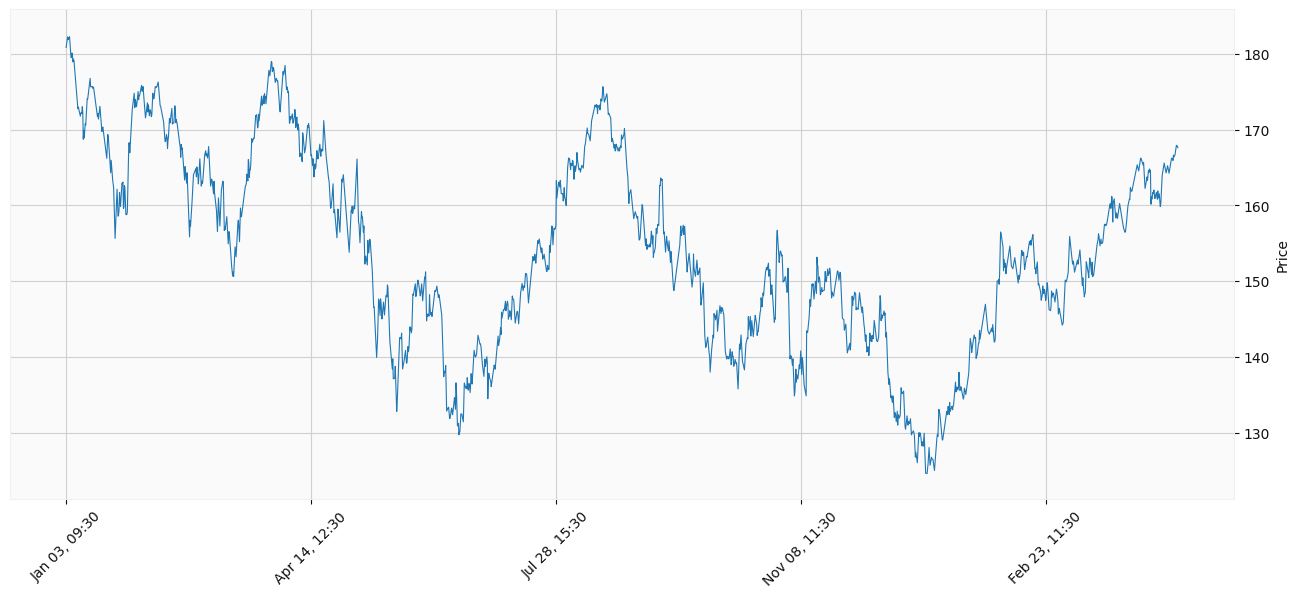

In [6]:
# отрисовываем график с mplfinance
mpf.plot(df_tiker, style= 'yahoo', type='line', figsize = (17, 7));


# Подготовка данных

## Функции для подготовки данных


In [7]:
def Trend_Matching(arr, step=1, window=20, comis=0):
    """ 
    функция идет вдоль тренда и находит точки смены тренда, 
    выдает точки массива начало тренда и конец и направление тренда
    direction
    -1 - падающий тренд
    0 - боковой
    1 - растущий
    """
    i = 0
    res = []
    len = arr.shape[0]
    cond_break = False
    while True:
        trend = None
        if step > len-i:
          res.append((0,arr.shape[0]-1, 0))
          return res
        for j in range(step, min(window, len-i)):
            # нам нужно проверить начнет ли расти диапазон, для этого нужно уже иметь первый диапазон
            #print("i, j, arri, arrj", i, j, arr[i], arr[i+j])
            delta = arr[i+j]*comis            
            if arr[i+j] - arr[i+j-1] - delta > 0:
              new_trend = 1
            elif arr[i+j]- arr[i+j-1] + delta < 0:
              new_trend = -1
            else:
              new_trend = 0    
            if trend == None:
              change_dir = False
              trend = new_trend
            else:
              change_dir = new_trend != trend
            end_array = i+j+1 == len
            if end_array:
              # конец массива, последний элемент, может быть другого тренда ...
              if change_dir:
                #print("смена тренда и конце массива")
                #print(i+1, i+j)
                res.append((i,i+j-1, trend))
                #print(i+j, i+j+1)
                res.append((i+j-1,i+j, new_trend))
                return res
              else:
                #print("тренд продолжается и конце массива")
                #print(i+1, i+j+1)
                res.append((i,i+j, trend))
                return res    
                # нужно завершить цикл ...
            else:
              if change_dir: # смена тренда, не на конце массива
                #print("смена тренда не на конце массива")
                #print(i+1, i+j)
                res.append((i,i+j-1, trend))
                # отходим на шаг назад, чтобы начать отслеживать новый тренд
                i += j-1
                trend = new_trend
                break
              #else:
                #print("тренд продолжается не на конце массива")
       
    return res        

def GrowRateGet(arr, i, trend, grow_rate=0.01):
  """
  функция считает степень роста вдоль тренда
  """
  trend_direction = trend[2]
  if trend_direction == 0:
    return 0
  delta = abs(arr[trend[1]] - arr[i])
  grow_rate_res = delta / arr[i]
  if grow_rate_res > grow_rate:
    grow_rate_res = 1
  else:
    grow_rate_res = grow_rate_res / grow_rate
  return grow_rate_res      

def Mathing_Signal_pred(arr, step=1, window=20, grow_rate = 0.01, comis=0):
  """ 
    функция идет вдоль тренда и находит точки смены тренда, 
    сохраняет глубину тренда - сколько периодов продолжается тренд
    length
    сохраняет в каждой точке степень роста тренда
    rate
    степень роста тренда считается так : от текущей точки до точки изменения направления тренда если степень роста больше grow_rate,
    то 100%, если меньше grow_rate то линейно от 0 до 100%   
    и сам тренд записывается значениями
    direction
    -1 - падающий тренд
    0 - боковой
    1 - растущий
    """
  signal = np.zeros((arr.shape[0], 3))
  for trend in Trend_Matching(arr, step, window, comis):
    for i in range(trend[0], trend[1]):
      signal[i, 0]= trend[2]
      signal[i,1] = trend[1]-i
      signal[i,2] = trend[2] * GrowRateGet(arr, i, trend, grow_rate)   
  return signal

def Mathing_Signal(df: pd.DataFrame, step=1, window=20, comis=COMIS):
  
  arr = df['Close']
  signal = Mathing_Signal_pred(arr, step, window, 0.01, comis)
  df['Signal'] = signal[:, 2]

  return df  
              

In [8]:
df_test = Mathing_Signal(df_tiker)

In [9]:
def add_sma(df: pd.DataFrame, windows:list, indicators: list):
    """ 
    data - типа OHCL
    Returns a pd.Series sma.
    """
    copy = df.copy()
    for window in windows:
      for col in indicators:
        copy[f'{col}_SMA_{window}'] = copy[col].rolling(window = window).mean()
    return copy

def add_diff(df: pd.DataFrame, depth: int, indicators: list, only_indicators = False):
    """
    df - DataFrame df типа OHCL
    depth - глубина сбора производных
    Returns a DataFrame with the vwap.
    """
    copy = df.copy() if not only_indicators else df[indicators].copy()
    # Расчет индикаторов относительной доходности
    for i in range(1, depth + 1):
        indicators_changes = [f'{ind}_diff_{i}' for ind in indicators]
        # Относительная доходность в сотых долях за период i шагов назад
        for indicator_change, indicator in zip(indicators_changes, indicators):
          copy[indicator_change] = copy[indicator].diff(periods=i)
    return copy

def add_ema(df: pd.DataFrame, windows:list, indicators: list):
    """ 
    data - типа df.Close
    Returns a pd.Series ema.
    """
    copy = df.copy()
    for window in windows:
      for col in indicators:
        copy[f'{col}_EMA_{window}'] = copy[col].ewm(span=window).mean()

    return copy

def add_macd(df: pd.DataFrame, indicators: list):
    """
    data - типа DataFrame
    Returns a pd.Series with the MACD.
    """
    copy = df.copy()
    for col in indicators:
      exp1 = copy[col].ewm(span=12, adjust=False).mean()
      exp2 = copy[col].ewm(span=26, adjust=False).mean()
      copy[f'{col}_MACD'] = exp1 - exp2
    return copy


def make_data(df:pd.DataFrame, depth: int, windows:list, 
              use_columns:list, rolls:list):
    copy = df.copy()
    # набираем мз чего дополняем данные
    copy = add_diff(copy, depth, use_columns, only_indicators = False)
    copy = add_ema(copy, windows,indicators = use_columns)
    copy = add_sma(copy, windows,indicators = use_columns)
    copy = add_macd(copy, indicators = use_columns)
    # оставляем use_columns и их производные 
    features = list(filter(lambda x: x.split('_')[0] in use_columns, copy.columns))
    return copy[features]


def add_from_datetime(df:pd.DataFrame):
    copy = df.copy()
    # делаем еще колонки на основе даты 
    hour =  1+copy.index.hour                      # час дня 
    day  =  1+copy.index.day                      # день месяца 
    week_day =  1+copy.index.dayofweek            # день недели  
    week  = 1+copy.index.isocalendar()['week']    # недели года
    month  = 1+copy.index.month                   # месяц  
    year  =  1+copy.index.year                    # год 
    dayofyear =1+copy.index.dayofyear             # день года
    mix_day = day*week_day*hour
    copy['Mix_day'] = np.log(mix_day).to_numpy()
    return copy

In [10]:
# обогощаем датасет на основе функции индикаторов 
FEATURES =  ['Open', 'High','Low', 'Close'] #, 'Adj Close'
DIFFBACK = 7
SET_WIND = [3, 7]
ROLLS = [5, 10]
df_data = make_data(df_tiker, DIFFBACK, SET_WIND, FEATURES, ROLLS)
df_data = add_from_datetime(df_data)

# переводим Volume в Log_Volume в df_data
df_data['Log_Volume'] = np.log(df_tiker['Volume'])

In [11]:
# параметр, который будем предсказывать
WIND_SMA = 12
use_column = 'Close'
PRED_PRICE = 'Signal'
print(f'Предсказывать будем цену - {PRED_PRICE}')

# добавляем колонку Close_SMA_12
df_data = Mathing_Signal(df_data)
# Удаление строк с неполными данными
df_data.dropna(inplace=True)
print(df_data.shape)

Предсказывать будем цену - Signal
(2264, 55)


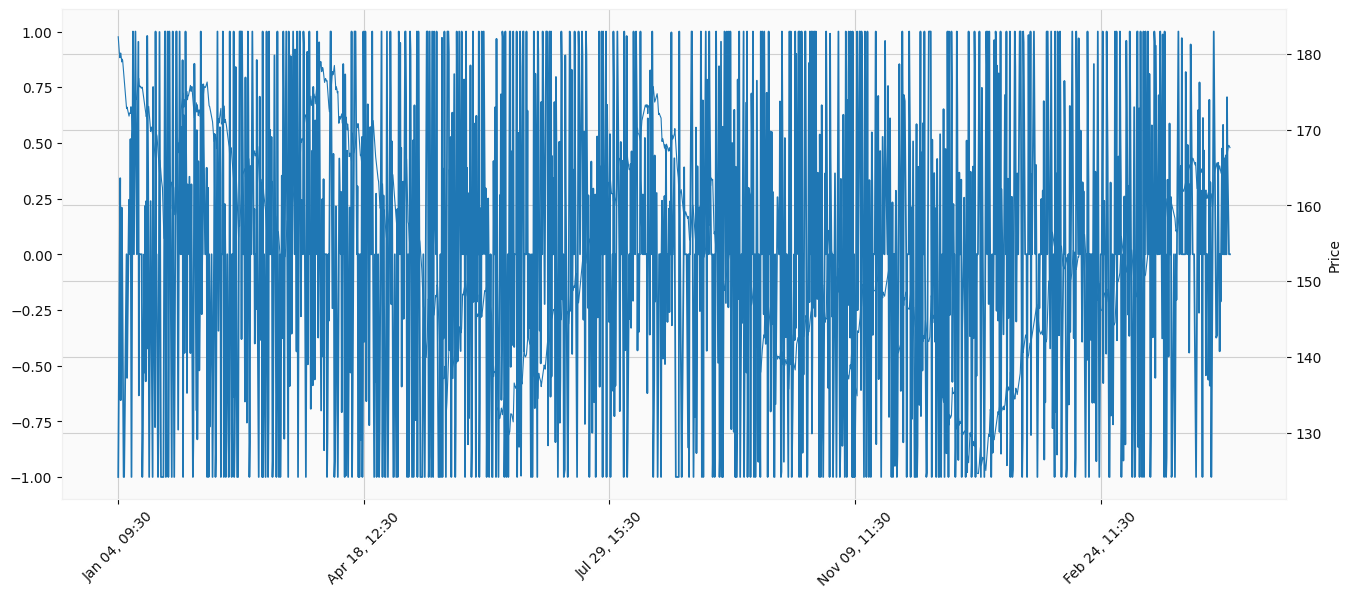

In [12]:
# отрисовываем график Close с добавленным графиком по колонке df_data[PRED_PRICE]
mpf.plot(df_data,  # датафрейм
         addplot= (mpf.make_addplot(df_data[PRED_PRICE])), # добавленый график df_data[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));

## Делим на Tain и Test


Учебный датасет


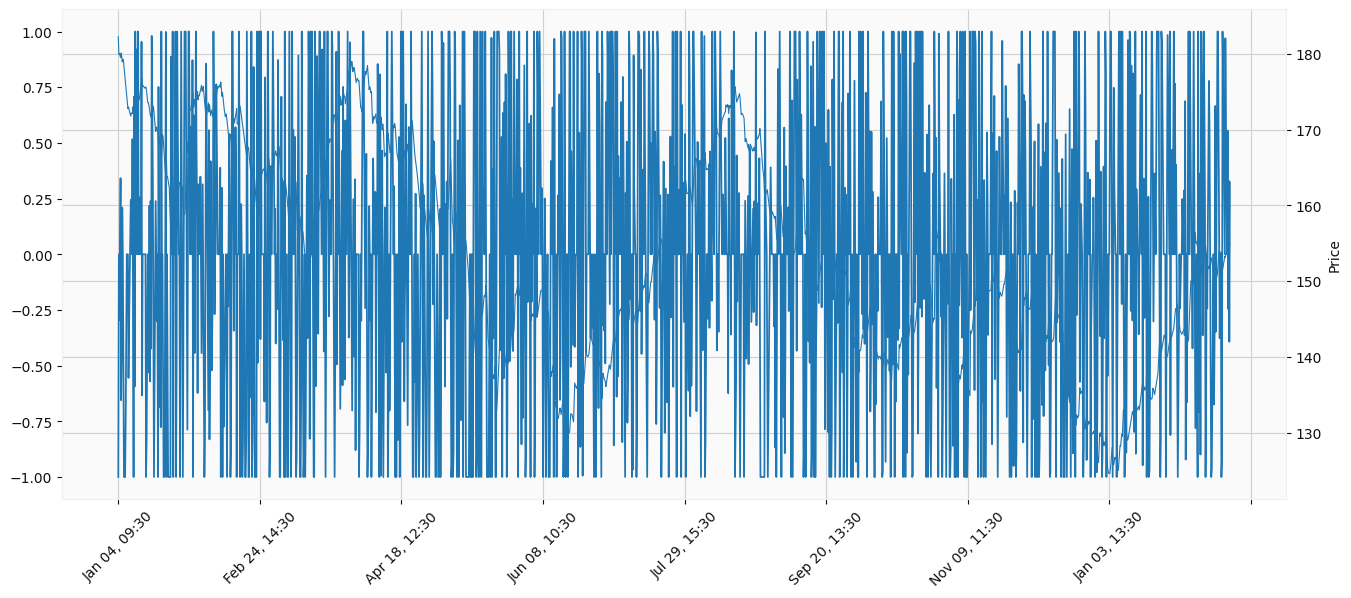

Тестовый датасет


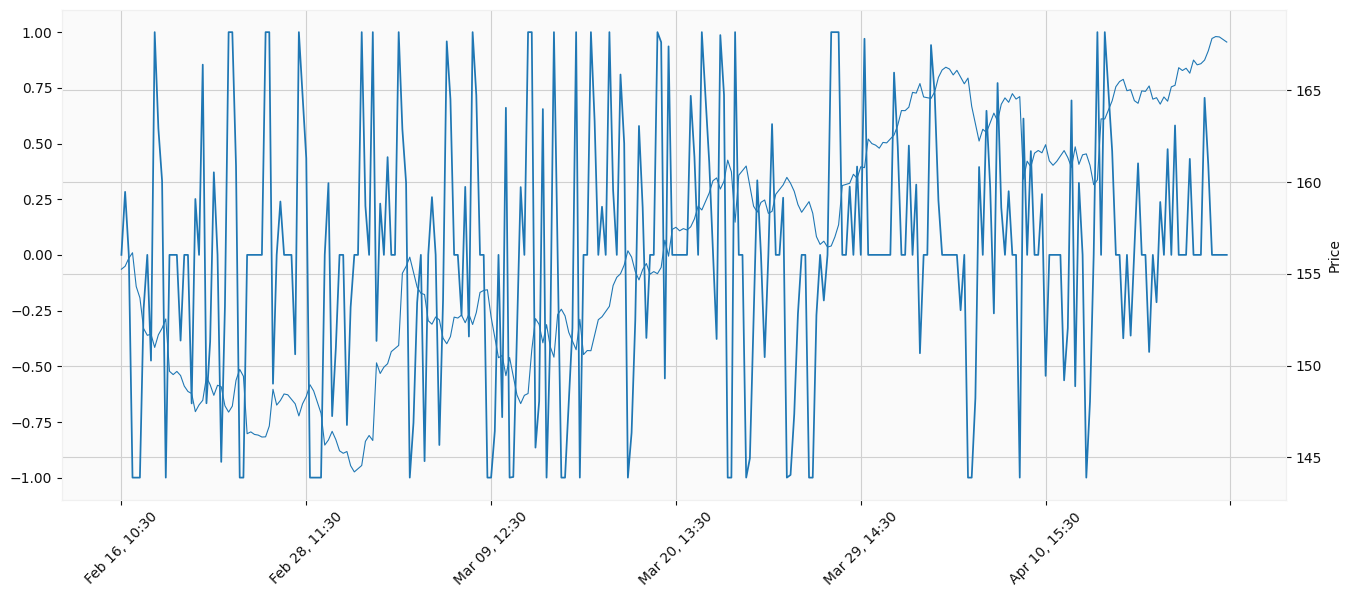

In [13]:
test_size = 300 # для теста откусим последние test_size значений
# Тренировочная выборка
print(f'Учебный датасет')
df_train = df_data[:-test_size]

# отрисовываем график Close с добавленным графиком по колонке df_train[PRED_PRICE]
mpf.plot(df_train,  # датафрейм
         addplot= (mpf.make_addplot(df_train[PRED_PRICE])), # добавленый график df_train[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));


# Тестовая выборка для симуляции торговли в реальном времени
print(f'Тестовый датасет')
df_test = df_data[-test_size:] 

# отрисовываем график Close с добавленным графиком по колонке df_test[PRED_PRICE]
mpf.plot(df_test,  # датафрейм
         addplot= (mpf.make_addplot(df_test[PRED_PRICE])), # добавленый график df_test[PRED_PRICE]
         style= 'yahoo', type='line', figsize = (17, 7));


## Подготовка данных для обучения

### Деление на Train датасет на TRAIN и VAL части

Предсказывать будем на 5ть шагов

In [14]:
# Формируем параметры загрузки данных
DEPTH = 29                               # Анализируем по 29 прошедшим точкам 
VAL_LEN = 300                            # Используем 300 записей для проверки
PREDICT_LAG = 1                          # на сколько шагов вперед       
TRAIN_LEN = df_train.shape[0] - VAL_LEN  # Размер тренировочной выборки
TRAIN_COLUMNS = df_train.columns[:-1]    # колонки для тренировочной выборки

# Делим данные на тренировочную и тестовую выборки 
x_train, x_val = df_train[TRAIN_COLUMNS][:TRAIN_LEN - PREDICT_LAG ], \
                 df_train[TRAIN_COLUMNS][TRAIN_LEN + DEPTH + 1 + PREDICT_LAG:-PREDICT_LAG]

x_train.shape, x_val.shape, TRAIN_LEN              

((1663, 54), (268, 54), 1664)

In [15]:
# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [16]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
X_SCAILER = MinMaxScaler(feature_range = (-1, 1)) #  RobustScaler() # StandardScaler() # 
X_SCAILER.fit(x_train)                  # обучаем X_SCAILER
x_train = X_SCAILER.transform(x_train)  # трансформируем x_train
x_val = X_SCAILER.transform(x_val)      # трансформируем x_val

x_train[0], x_val[0]

(array([ 1.        ,  1.        ,  1.        ,  1.        ,  0.12538328,
        -0.17201393,  0.1492129 , -0.17168731,  0.08882587, -0.02100526,
        -0.13185775, -0.19579373,  0.04705882, -0.01792678, -0.11380969,
         0.0284257 ,  0.12926446,  0.05729035, -0.08986042,  0.01269353,
         0.07122838,  0.07085333,  0.02514384,  0.05184166,  0.12988703,
         0.07926046,  0.09773199,  0.02270794,  0.43775181,  0.1131527 ,
         0.32568938,  0.10574253,  0.99824328,  0.99850342,  1.        ,
         1.        ,  0.99522439,  0.99721885,  1.        ,  1.        ,
         0.99313407,  0.99499139,  1.        ,  1.        ,  0.99140293,
         0.99492449,  1.        ,  1.        ,  0.46373137,  0.20703855,
         0.39323004,  0.18726543, -0.33222245,  0.35232904]),
 array([-9.16824326e-01, -9.28978542e-01, -9.05433350e-01, -9.09930286e-01,
         1.18907507e-02, -3.51732675e-01,  6.66318074e-02, -1.81710754e-01,
        -3.97025399e-02, -1.36296786e-01, -1.41078809e-0

In [23]:
# Функция разделения набора данных на выборки для обучения нейросети 
# x_data - набор входных данных
# predict_lag - количество шагов в будущее для предсказания
def future_sequence(x_data, predict_lag):
    # Определение максимального индекса
    y_len = x_data.shape[0] - (predict_lag - 1)
    # отстоящих на predict_lag шагов вперед
    y = [x_data[i:i+ predict_lag] for i in range(y_len)] 
    # Возврат результатов в виде массивов numpy
    return np.array(y)

In [29]:
# Для подготовки yTrain на PREDICT_LAG шагов вперед необходимо создать дополнительный датасет
# Для таргета берем колонку PRED_PRICE
y_train = future_sequence(df_train[PRED_PRICE][:TRAIN_LEN - PREDICT_LAG], PREDICT_LAG)
y_val =  future_sequence(df_train[PRED_PRICE][TRAIN_LEN + DEPTH + 1 + PREDICT_LAG:-PREDICT_LAG], PREDICT_LAG)

# делаем ли np.log для у
MAKE_LOG = False
if MAKE_LOG:
  y_train = np.log(y_train)  # заменяем  y_train на log(y_train)
  y_val = np.log(y_val)      # заменяем  y_val на log(y_val)

print(y_train.shape, y_val.shape)
y_train[0], y_val[0]

(1663, 1) (268, 1)


(array([-1.]), array([0.]))

In [25]:
y_train

array([[-1.        ],
       [ 0.        ],
       [-0.2943947 ],
       ...,
       [ 0.        ],
       [ 0.36433545],
       [ 0.        ]])

In [30]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Y_SCAILER = MinMaxScaler(feature_range = (0, 1)) #  RobustScaler() # StandardScaler() # 
Y_SCAILER.fit(y_train)                    # обучаем Y_SCAILER
y_train = Y_SCAILER.transform(y_train)    # трансформируем y_train
y_val = Y_SCAILER.transform(y_val)        # трансформируем y_val

y_train[0], y_val[0]

(array([0.]), array([0.5]))

### Формируем генератор данных TimeseriesGenerator
- https://ru-keras.com/sequence-preprocessing/
- https://keras.io/api/preprocessing/timeseries/
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator

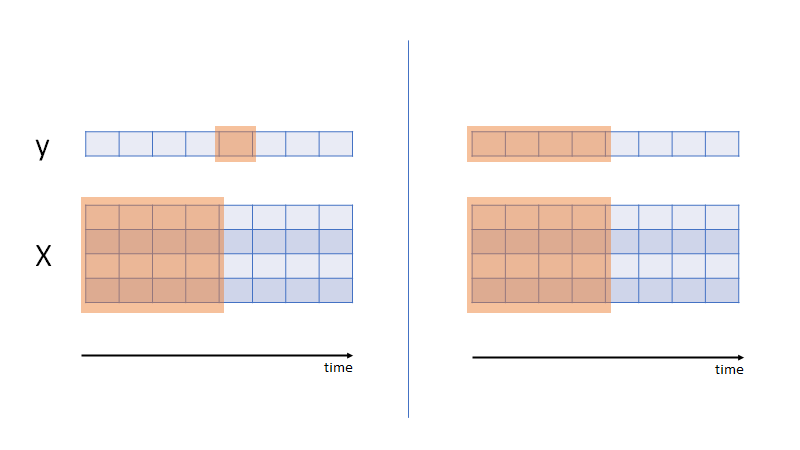

In [27]:
# Для генерации выборки временных рядов
TSG = tf.keras.preprocessing.sequence.TimeseriesGenerator 

In [31]:
BATCH_SIZE = 20
# Создаем генератор для обучения
train_datagen = TSG(x_train, y_train,          # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам 
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

# Создаем аналогичный генератор для валидации при обучении
val_datagen = TSG(x_val, y_val,                # В качестве параметров наши выборки
                    length = DEPTH,            # Анализируем по 21 прошедшим точкам 
                    sampling_rate = 1,         # Для каждой точки
                    batch_size = BATCH_SIZE)   # Размер batch, который будем скармливать модели

print(train_datagen[0][0].shape,
      val_datagen[0][1].shape)

# запомним входную размерность для модели обучения
INSHAPE = train_datagen[0][0].shape[1:]

(20, 29, 54) (20, 1)


In [32]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
DataGen = TSG(x_val, y_val,              # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам 
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_val))   # Размер batch будет равен длине нашей выборки


# сформируем сами массивы для проверки
XVAL, YVAL = [], []
for i in DataGen:
  XVAL.append(i[0])
  YVAL.append(i[1])

# так как это список объектов
# мы вытаскиваем нужный нам
XVAL = np.array(XVAL)[0]
YVAL = np.array(YVAL)[0]
print(XVAL.shape,YVAL.shape)

(239, 29, 54) (239, 1)


# Классы для генерации случайной нейронной сети

In [35]:
import random as random # Импортируем модель randim
import inspect # для получения имен аргументов функции

## Класс для определения слоев

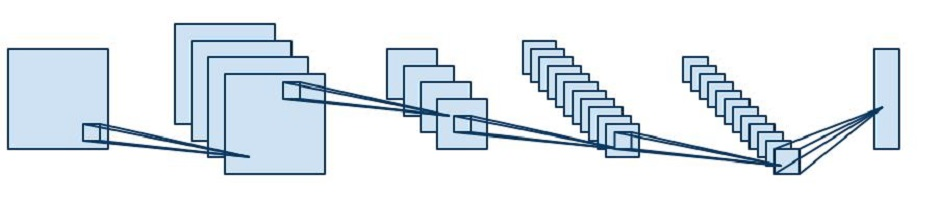

In [36]:
class Set_net():
    '''
    Класс для формирования списка списков блоков,
    имен слоев и значений парамметров слоев
    type_net       - тип сети:
                     0 - Dense
                     1 - Conv
                     2 - Recur
                     None - любая
    activ_lays     - список функций активаций 
    activ_out      - выходная функция активации
    neiro_out      -  количество нейронов/сверток выходного слоя 
    limit          -  ограничения роста сети 
                      по умолчание 10**3 
    '''
    def __init__(self,
                 type_net,      # тип сети
                 activ_lays,    # список функций активаций 
                 activ_out,     # выходная функция активации
                 neiro_out,     # количество нейронов/сверток выходного слоя 
                 limit = 10**3, # ограничения роста сети   
                 ) -> None:

        # списки имен используемых слоев
        self.main_lays =  ['Dense', 'Conv1D']
        self.recur_lays = ['Lstm', 'BiEmbLstm']
        self.add_lays =   ['SCnv1D', 'Conv1DT', 'Conv1D_dilation_block']
        self.optim_lays = ['Dropout','BatchN', 'LayNorm']
        self.pooling_lays = ['MaxP1D','AvgP1D', 'Ups1D']
        self.embed_lays =   ['Embed']
        self.activ_lays = activ_lays
        self.activ_out = activ_out
        self.neiro_out = neiro_out

        # все используемые именя слоев
        self.use_layers  = self.main_lays + self.recur_lays + self.optim_lays\
                           + self.pooling_lays + self.embed_lays\
                           + self.add_lays + ['activ',]

        # создаем self переменные
        self.type_net = type_net
        self.limit = limit
        self.layer = tf.keras.layers

        # создаем список функций слоев
        self.makers_layer = (self.make_dense,
                             self.make_conv1D,
                             self.make_lstm,
                             self.make_biemblstm,
                             self.make_dropout,
                             self.make_batchn,
                             self.make_laynorm,
                             self.make_maxp1D,
                             self.make_avg1D,
                             self.make_upsam1D,
                             self.make_embedding,
                             self.make_sepconv1D,
                             self.make_conv1DT,
                             self.make_convblock_dilation,
                             self.make_activ,
        )
        # создаем словарь соответсвия имен и функций слоев
        self.dict_layers = dict(zip(self.use_layers, self.makers_layer))
        pass
    
    # Функции создания слоев
    def make_dropout(self, x, rate):
        lay = self.layer.Dropout(rate)(x)
        return lay

    def make_batchn(self, x):
        lay = self.layer.BatchNormalization()(x)
        return lay   

    def make_laynorm(self, x):
        lay = self.layer.LayerNormalization()(x)
        return lay   

    def make_dense(self,x, neiron):
        lay = self.layer.Dense(neiron)(x)
        return lay

    def make_conv1D(self, x, filter, kernel):
        # корректируем размерность под conv1D
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.Conv1D(filters = filter, 
                                kernel_size = kernel,
                                padding = 'same')(x)
        return lay

    def make_sepconv1D(self, x, filter, kernel):
         # корректируем размерность под conv1DT
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.SeparableConvolution1D(filters = filter, 
                                                kernel_size = kernel,
                                                padding = 'same')(x) 
        return lay

    def make_conv1DT(self, x, filter,  kernel):
        # корректируем размерность под conv1DT
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.Conv1DTranspose(filters = filter,
                                         kernel_size = kernel,
                                         padding = 'same')(x)
        return lay


    def make_maxp1D(self, x, pool):
        lay = self.layer.MaxPooling1D(pool_size = pool)(x)
        return lay

    def make_avg1D(self, x, pool):
        lay = self.layer.AveragePooling1D(pool_size = pool)(x)
        return lay

    def make_upsam1D(self, x, upsize):
        lay = self.layer.UpSampling1D(size = upsize)(x) 
        return lay   


    def make_lstm(self, x, lstmon):
        # корректируем размерность под LSTM
        if len(x.shape) < 3:
           x = self.layer.Reshape((-1,1))(x)
        lay = self.layer.LSTM(units = lstmon,
                              return_sequences = True,
                              )(x)
        return lay

    def make_embedding(self, x, in_emb, out_emb):
        # корректируем размерность под LSTM
        if len(x.shape) > 2: 
          x = self.layer.Flatten()(x)
        lay = self.layer.Embedding(input_dim = in_emb, 
                                             output_dim = out_emb)(x)                            
        return lay

    def make_biemblstm(self, x, lstmon):
        # корректируем размерность под LSTM
        if len(x.shape) > 2: 
           x = self.layer.Flatten()(x)
        # парамметры для Embedding слоя
        emb_in = x.shape[1]
        emb_out = min(64, emb_in//3)
        lay = self.layer.Embedding(input_dim = emb_in, 
                                              output_dim = emb_out)(x)
        lay = self.layer.Bidirectional(self.layer.LSTM(lstmon,
                                                      return_sequences=True))(lay)
        lay = self.layer.Bidirectional(self.layer.LSTM(lstmon,
                                                      return_sequences=False))(lay)
        return lay
      
    def make_convblock_dilation(self, x, filter,  kernel):
        def convs(x, n, f, rate, ln = False):
            x = self.layer.Conv1D(n, f, padding = "causal",
                            dilation_rate = rate,
                            activation="sigmoid")(x)
            x = self.layer.LayerNormalization()(x) if ln else x
            return x  
        # корректируем размерность под conv1DT
        if len(x.shape) < 3:
            x = self.layer.Reshape((-1,1))(x)
        a = convs(x = x, n = filter,  f = filter, rate = 2, ln = True)
        b = convs(x = x, n = filter,  f = filter, rate = 4, ln = True)
        c = convs(x = x, n = filter,  f = filter, rate = 8, ln = True)
        d = convs(x = x, n = filter,  f = filter, rate = 16, ln = True)
        lay = self.layer.concatenate([x, a, b, c, d], axis = -1)
        return lay

    def make_activ(self, x, activ):
        lay = self.layer.Activation(activ)(x)
        return lay   
 

    # Метод построение случайного бота блока на основе bot_list блока 
    def __buildbot__(self, bot_list):
        '''
        Метод создает случайным образом в заданном диапазоне
        значения пришедщим парраметрам слоев в списке bot_list
        собирает их в список и выдает этот список
        '''
        bot = []
        for el in bot_list:
            if el == 'neiron':
                bot.append(2**random.randint(2,7))
            if el == 'activ':
                bot.append(random.randint(0, len(self.activ_lays)-1))
            if el == 'filter':
                bot.append(2**random.randint(2,7))
            if el == 'kernel':
                bot.append(random.randint(2,5))
            if el == 'pads':
                bot.append(random.choice(('valid','same')))
            if el == 'stride':
                bot.append(random.randint(1,2))
            if el == 'pool':
                bot.append(random.randint(2,4))
            if el == 'upsize':
                bot.append(random.randint(2,4))
            if el == 'rate':
                bot.append(round(random.random()*0.5,2)) 
            if el == 'lstmon':
                bot.append(random.randint(2,30))
            if el == 'in_emb':
                bot.append(random.randint(10,200))
            if el == 'out_emb':
                bot.append(max(20, bot[-1]//3))
        return bot

## Класс генерация блоков

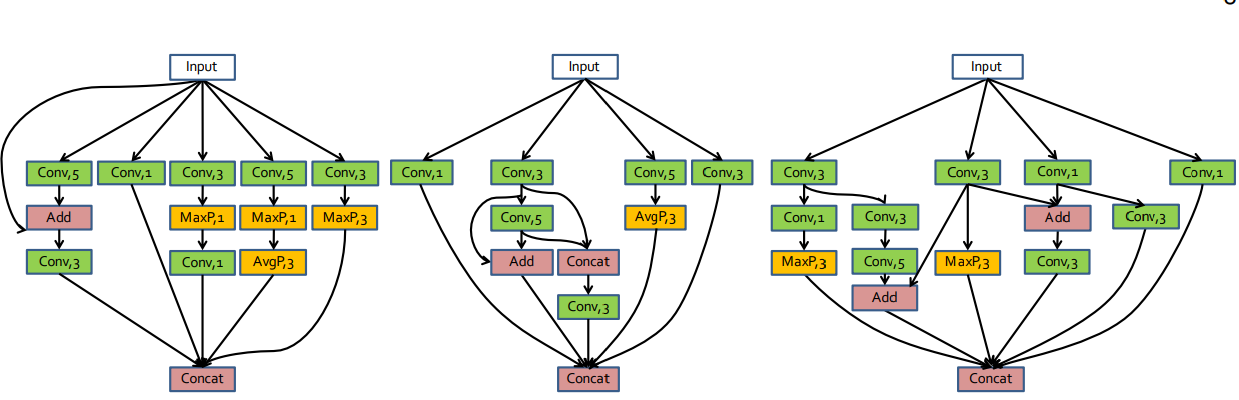

In [37]:
class Make_blocks():
    '''
    Класс отвечающий за генерацию 
    блоков сети на основе данных из 
    ранее инициализированного класса set_net

    set_net - класс парамметров сети
    '''
   
    def __init__(self,
                set_net: object,                 
                ):
        # переназначенм переменные из класса set_net
        self.set_net = set_net  
        self.neiro_out = set_net.neiro_out   
        self.main_lays = set_net.main_lays
        self.add_lays = set_net.add_lays
        self.recur_lays = set_net.recur_lays 
        self.activ_out = set_net.activ_out
        self.limit = set_net.limit
        self.type_net = set_net.type_net

        # определяем слои сети на основы заданного типа сети
        #############################################
        # если тип не задан
        if self.type_net == None:   
            self.net_lays = self.main_lays + self.add_lays + self.recur_lays 
        # если рекурентный тип сети
        elif self.type_net == 2:
            self.net_lays = self.recur_lays
        # если 0 - Dense или 1 - Conv тип сети
        else:
            # выбираем из main_lays индексом, который равен типу сети
            self.net_lays = [self.main_lays[self.type_net]]
        #############################################
        # отобранные по типу слою и плюс слои оптимизации 
        self.__used_lays__ = self.net_lays + self.set_net.optim_lays

        pass

    # ФУНКЦИИ КОРРЕКЦИИ СПИСКОВ БЛОКОВ
    def __correct__(self, block_list: list, name: str,
                   level = 0, insert = False):
        '''
        Метод коррекции пришедщего списка списка
        block_list - пришедщий список
        level - порог выше котого коррекция
        name - имя добавляемого слоя
        insert - если True то вставит до последнего,
              иначе вставит за последним
        '''
        # подбрасываем монетку
        bias = random.random()
        if bias >= level: # если выше порога, то корректируем для вывода
            if insert: # вставляем 
               block_list.insert(-1, name)
            else: # добавляем 
               block_list.append(name)
        return block_list

    # ФУНКЦИИ ГЕНЕРАЦИИ СПИСКОВ БЛОКОВ
    def __generateblock__(self,
                        max_lays: int,        # мак.количество слоев в блоке
                        prob_mp = 0.47,       # появление пуллинг слоя
                        prob_el = 0.65,       # Embedding до LSTM
                        prob_ac = 0.33        # появление слоя активации
                        ):
        '''
        Внутренний метод для геннерации списка
        из имен слоев
        max_lays - мак. возможное количество слоев в блоке
        '''       
        # определяем количество слоев в блоке не более max_lays  
        layers = random.randint(0, max_lays) 
        block_list = [] # список для сбора имен слоев
        # итерируемся по слоям
        for i in range(layers):
            if not i: # если 0_й слой
              # вставляем случайное имя из слоев сети
              block_list = self.__correct__(block_list,
                                            random.choice(self.net_lays))
            else:          
              # если пришло имя из слоя оптимизации
              if block_list[-1] in self.set_net.optim_lays:
                # вставляем случайное имя из слоев сети
                block_list = self.__correct__(block_list,
                                            random.choice(self.net_lays))
              else: # иначе выбираем из слоев сети и оптимизации
                block_list = self.__correct__(block_list,
                                          random.choice(self.__used_lays__))           
              # случайное появление пулинга после cвертки
              if block_list[-1]=="Conv1D" and i < layers:
                # случайно по prob_mp добавляем пуллинг слой
                block_list = self.__correct__(block_list,
                                      random.choice(self.set_net.pooling_lays),
                                      level = prob_mp)
              # случайное появление Embeding переd LSTM
              if block_list[-1]=="Lstm" and i < layers:
                # случайно по prob_el вставляем Embeding слой переd LSTM
                block_list = self.__correct__(block_list,
                                            self.set_net.embed_lays[0],
                                            level = prob_el,
                                            insert = True)
              # случайное появление активации
              if block_list[-1] != 'activ' and i < layers:
                # случайно по prob_ac добавляем 'activ'
                block_list = self.__correct__(block_list, 'activ',
                                            level = prob_ac)
              # если набрали длину 
              if len(block_list) == layers:
                  break

        return block_list


    def sostav_blockov(self, q_lst: list): 
        '''
        Метод генерирует список из списков блоков
        размера полученнного из q_lst
        q_lst - список длины количества блоков,
                где значения списка определяет 
                количество слоев в блоке
        '''
        blockov_list = []
        for i in range(len(q_lst)):
            block = self.__generateblock__(max_lays = q_lst[i])
            blockov_list.append(block) 
        return  blockov_list  


    def buildblock_bot(self, block_lst: list):
        '''
        Метод собирает список списков парамметров
        слоев каждого блока будущей сети
        block_lst - список списков слоев будущей сети
        '''
        botov_lst = []
        for i in range(len(block_lst)):
            # получаем список имен парамметров слоев блока
            bot_lst = self.__bot_block__(block_lst[i]) 
            # получаем список самих парамметров слоев блока из имен парамметров
            bot = self.set_net.__buildbot__(bot_lst)
            botov_lst.append(bot) 
        return   botov_lst 

    ######################################################################

    # ФУНКЦИИ БОТОВ
    # определение состава бота для блока из созданого случайно block_list
    def __bot_block__(self, block_list: list):
        '''
        Метод формирует список списков парамметров слоев в блоках
        на основе списка имен слоев блока из block_list
        block_list - список имен слоев блока
        '''
        bot_list = []
        for lay in block_list:
          if lay == 'activ':
              # если имя слоя 'activ', то просто добавляем 'activ'
              bot_list.append('activ') 
          else: # иначе
              # созданный в set_net словарь соответсвия
              # имен слоев и функций их формирующих
              maker_lay = self.set_net.dict_layers[lay]
              # методом param_layer определяем парамметры 
              # у функций формирующих слои
              param = self.__param_layer__(maker_lay)
              # добавляем эти парамметры в bot_list
              if len(param): bot_list += param 
              else: pass
        return bot_list


    # Построение случайного бота попупуляции 
    def buildpopulbot(self, q_tyblocks: int, q_lays: int):
        '''
        Метод случйно генерирует список, который будет
        ботом_попупаляции сетей
        q_tyblocks - максимально возможное количество блоков в сети
        q_lays - максимально возможное количество слоев в блоках в сети
        '''
        # генерируем количество блоков
        qblocks = random.randint(1, q_tyblocks)  
        # генерируем количество слоев в блоке 
        genlays = random.randint(1, q_lays)  
        
        # собираем бота популяции
        populbot = []
        # добавляем ген макс. возможное количество блоков сети популяции
        populbot.append(qblocks)   
        # добавляем ген макс. возможное количество слоев в блоках сети популяции
        populbot.append(genlays) 
        # ген типа данной сети
        populbot.append(self.type_net) 
        # ген делать или нет пред_выходном слой
        populbot.append(random.randint(0,1)) 
        # ген ко-ва нейронов/фильтров пред_выходном слое
        populbot.append(2**random.randint(2,7)) 
        # ген окон если свертки в пред_выходном слое
        populbot.append(random.randint(2,5)) 
        # ген делать/нет слой нормализации перед посл-й активацией    
        populbot.append(random.randint(0,1)) 
        # ген какую делаем активацию в пред_выходном слое из списка активаций
        populbot.append(random.randint(0, len(self.set_net.activ_out)-1)) 
        # ген под сложность сети, будет назначается методом сборки сети
        populbot.append(0) 
        # ген под ярусность сети, будет назначается методом сборки сети
        populbot.append(0)                   
        return populbot

        
    # ФУНКЦИИ ФОРМИРОВАНИЯ БЛОКОВ
    # без степеней - прямые значения нейронов
    def __buildblock__(self, tensor: object,
                       block_list: list, bot: list):
        '''
        Метод строет блок слоев на основе списка 
        имен слоев блока и им соответствующих бота,
        являющегося списком парамметров этих слоев
        input:
        tensor     - входящий тензор
        block_list - список имен слоев блока
        bot        - спискок парамметров этих слоев
        output:
        tensor     - исходящий тензор блока
        '''
        
        # будет добавляться больше или меньше 0 значение 
        # если к-во параметров > или < 1
        b=0 
        # иттерируеимя по слоям блока
        for i, lay in enumerate(block_list):
          # созданный в set_net словарь соответсвия
          # имен слоев и функций их формирующих
          maker_lay = self.set_net.dict_layers[lay]
          # получаем колчество парамметров функции слоя
          k = len(self.__param_layer__(maker_lay))
          # формируем список аргументов для функции слоя
          if k: # если есть доп.параметры в слое
            # получаем доп.параметры в слоя
            parametrs = [bot[i+b+j] for j in range(k)]
            # собираем аргументы для активации
            if lay=='activ':
              args = [tensor]+[self.set_net.activ_lays[parametrs[0]]]
            # собираем аргументы для других многопарамметных слоев
            else: args = [tensor]+parametrs
          # собираем аргументы если слой без параммeтров
          else: args=[tensor]
          # формируем слой на основе нужных и собранных args
          tensor = maker_lay(*args)
          # обнавляем b
          b+=k-1
        return tensor # выводим выходной тензор блока


    def __buildblockout__(self,
                      indata: object,    # входные данные
                      bot_pop: list,     # бот популяции (может)
                       ):
        '''
        Метод строет блок слоев на основе списка 
        имен слоев блока и им соответствующих бота,
        являющегося списком парамметров этих слоев
        input:
        tensor     - входящий тензор
        block_list - список имен слоев блока
        bot        - спискок парамметров этих слоев
        output:
        tensor     - исходящий тензор блока
        '''
        x = indata

        if bot_pop[2] == 0:
            # Добавление предпоследнего полносвязного слоя
            if bot_pop[3]!=0:
                x = self.set_net.make_dense(x, bot_pop[4])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x) 

        elif bot_pop[2] == 1:
            # Добавление предпоследнего conv1D слоя
            if bot_pop[3]!=0:
                # высчитываеи корректировку размерности тензора под conv1D
                newshape = self.__redim__(x.shape[1], 2, sort = 0)
                x = tf.keras.layers.Reshape(newshape)(x)
                x = self.set_net.make_conv1D(x, bot_pop[4], bot_pop[5])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x) 

        elif bot_pop[2] == 2:
            # Добавление предпоследнего LSTM слоя
            if bot_pop[3]!=0:
                # высчитываеи корректировку размерности тензора под lstm
                newshape = self.__redim__(x.shape[1], 2, sort = 0)
                x = tf.keras.layers.Reshape(newshape)(x)
                x = self.set_net.make_lstm(x, bot_pop[4])
            # Добавление нормализации перед последним полносвязным слоем
            if bot_pop[6]!=0: x = self.set_net.make_batchn(x) 

        else: pass 
        return x

    ###########################################################
    ######         вспомогательные методы класса         ######
    ###########################################################
    def __param_layer__(self, method: object):
        '''
        Метод выводит количеству управляющих
        парамметров пришедшей функции method
        на онове inspect.getfullargspec
        method - функция у которой определяютя 
                 количество управляющих парамметров
        '''
        return inspect.getfullargspec(method).args[2:]


    # простое соединение произвольного к-ва блоков
    def __flatconcat__(self, set_blocks: list):
        '''
        Метод конкантенации списка тензоров блоков
        через промежуточный перевод в вектор Flatten
        с контролем пространства паремметров и при
        превышении к-ва размерностей или размера 
        паремметров, применение GlobalAveragePooling1D
        взамен Flatten
        '''
        out = []
        # иттерируемся по списку тензоров
        for i in range(len(set_blocks)):
            # не является ли уже вектором
            if set_blocks[i].shape != (None, 1): 
                # Берем shape тензора         
                control_shape = set_blocks[i].get_shape()
                # Если много размерностей или много парамметров у тензора
                if np.prod(control_shape[1:]) > self.limit \
                 and len(control_shape) > 3:
                    # Добавляем слой GlobalAveragePooling1D
                    lay = tf.keras.layers.GlobalAveragePooling1D()(set_blocks[i])
                    out.append(lay)               
                else: # Добавляем слой Flatten
                    lay = tf.keras.layers.Flatten()(set_blocks[i])
                    out.append(lay)
            else: # Иначе выходим
                break
        # Конкантенируем тензоры по axis = -1 и выводим
        out = tf.keras.layers.concatenate(out, axis = -1)
        return  out        


    def __redim__(self, size, dim, sort = None):
        '''
        Метод метод считает выходной список размерностей
        длины dim из прешедшего размера парамметров size,
        на основе разложения на простые множители
        input:
        size - входящий размер размерности слоя
        dim  - длина всписка выходной размерности
        sort - сортировать ли список простых множителей
                как - 0 - возраст-й, 1 - убывающий
        output:
        outshape - выходной список размерностей
                   длины dim
        '''
        # собираем в res простые множители чиcла n
        res, n, d = [], size, 2
        while d * d <= n:
            if n % d == 0:
                res.append(d)
                n //= d
            else:
                d += 1
        if n > 1:
            res.append(n) 
        ##########################################
        
        # сортируем или перемешиваем список простых множителей
        if sort == 0 or sort == 1:
            res = sorted(res, reverse=sort)
        else:      
            res = np.random.permutation(res)
        ##########################################

        # формируем список размерностей длины dim   
        s = len(res)//dim  # целое число отношения len(res) и dim
        if s >= 1 and dim == 2:
            # получим outshape размерности 2 из произведений частей
            outshape = [np.prod(res[:s]), np.prod(res[s:])]

        elif s >= 1 and dim == 3:
            # получим outshape размерности 3 из произведений частей
            outshape = [np.prod(res[:s]), np.prod(res[s:2*s]),
                         np.prod(res[2*s:])]

        elif s < 1 and dim == 3:
            s = len(res)//(dim-1)
            # получим outshape размерности 2 из произведений частей и 
            # добавляем ось справа
            outshape = [int(np.prod(res[:s])), int(np.prod(res[s:])), 1]

        elif (s < 1 and dim == 2) or dim == 1:
            # просто добавляем ось справа
            outshape = [size, 1]       
      
        return outshape

## Класс сборки нейронки

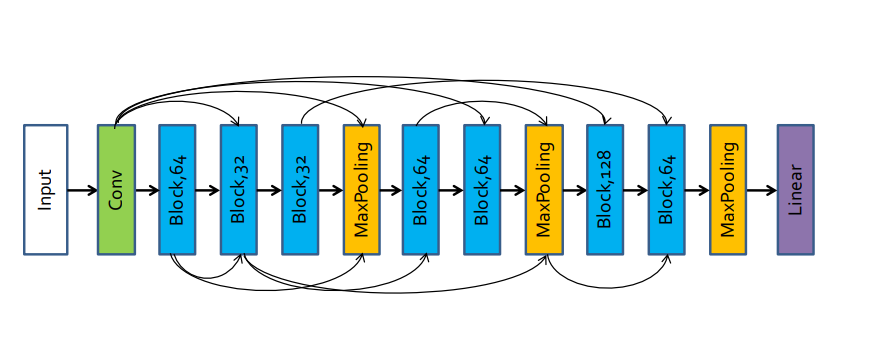

In [38]:
!pip install stopit -q # установка библиотека контроля времени
from stopit import threading_timeoutable as timeoutable

  Preparing metadata (setup.py) ... done


In [39]:
MESSAGE_1 = 'Превышение лимита на сборку модели'
TIMELIMIT_1 = 5 # лимит времени в секундах на сборку модели

MESSAGE_2 = 'Превышение лимита на тестовое обучение модели'
TIMELIMIT_2 = 20 # лимит времени на тестовое обучение модели

In [40]:
class WildregressModel():
      '''
      Класс который формирует и выдает сеть

      input_shape - размерность входящих в сеть данных
      control_level_shape - размер допустимого размера парамметров 
                            слоев когда требуется применение 
                            GlobalAveragePooling1D для понижения
                            размерности, по умолчанию 10**3
      q_level - количество блоков с которого можно строить 
                многоярусную сет, по умолчанию 3
      '''
      
      def __init__(self,
                  input_shape: list,
                  control_level_shape = 10**3,
                  q_level = 3
                  ):
        
          self.input_shape = input_shape
          self.control = control_level_shape
          self.q_level = q_level
          pass
          
      # Декоратор для контроля времени
      @timeoutable(default = MESSAGE_1)        
      def __call__(self,
                  bot_pop: list,
                  bot: list,
                  setblockov: list,
                  blocks: object
                  ):
          '''
          Класс который формирует и выдает сеть на основе
          bot_pop - бот_популяции сетей
          bot - спискок парамметров слоев блоков
          setblockov - списка списков слоев имен блока
          blocks - класс построения блоков
          '''
          # Входной слой
          inputs =  tf.keras.layers.Input(self.input_shape)  
          # размерность даннх сети без 0го, которы None
          dim_net = len(self.input_shape) - 1

          ##### отбор блоков с основными слоями для входа нейронки ############
          idx=[] # хранения индексов блоков с основными слями сети 
          # отбираем индексы блоков с основными слями сети
          for block in setblockov:
              if [x for x in blocks.net_lays if x in block]:
                idx.append(setblockov.index(block)) 
          # берем первый по счету, и если был посев, для входа уходит сразу
          in_nb = idx[0] 
          # получаем тензор от первого блока
          in_block = blocks.__buildblock__(inputs, setblockov[in_nb],
                                           bot[in_nb])

          #####################################################################
          ############# отбор для скрытых блоков ##############################
          # ищем и оставляем только один пустой блок 
          new_setblockov = []
          new_bot = []
          emp = 0 # счетчик пустых блоков

          # Если был посев, то первый блок для входа уходит сразу -
          for i in range(1,len(setblockov)): # не попадет во внутр.блоки
              #print('metka 4')                                    
              if emp == 0 and setblockov[i] == []:
                  new_setblockov.append(setblockov[i])
                  new_bot.append(bot[i])
                  emp+= 1 
              elif emp != 0 and setblockov[i] == []:
                  pass    
          # оставляем только один пустой блок
          # на его основе создается проброс от входной части до concat
              else:    
                  new_setblockov.append(setblockov[i])
                  new_bot.append(bot[i])  

          #####################################################################
          #  print('Сборка многоярусной модели')
          #####################################################################
          if len(new_setblockov) > self.q_level:
              ############### БЛОК соединения скрытых блоков  #################
              ########## создание гена для ярусности и  сложности сети ########
              if not bot_pop[9]:
                  # определяем ярусность сети
                  bot_pop[8] = random.choice(np.arange(2,
                                                       len(new_setblockov)-1))
                   # отбор блоков в ярусы
                  bot_pop[9] = [0] + [len(new_setblockov)] \
                                   + sorted(np.random.choice(np.arange(1,
                                            len(new_setblockov)-1),              
                                            bot_pop[8], replace=False))                                                                                      
                  tiers = bot_pop[9]  # состав ярусов
              else:
                  tiers = bot_pop[9]  # состав ярусов
            ###################################################################
              brickblock = [] # ссписок для сборв внутренних блоков
              # итеррируемся по ярусам
              for j in range(len(tiers)-1):
                  indata = in_block if not j else concdata
                  hidblock = []
                  # отбираем в conc только возможные блоки
                  for i in range(tiers[j], tiers[j+1]):
                      ##########################################################
                      # создаем внутренний блок
                      hid = blocks.__buildblock__(indata,
                                              new_setblockov[i],
                                              new_bot[i])
                      # собираем список внутренних блоков для конкатенации
                      hidblock.append(hid)
                  # еслм набрали в список внутренних блоков
                  if len(hidblock):
                    # конкатенируем через выпрямления в вектора
                    concdata = blocks.__flatconcat__(hidblock)
                    # ищем замену размерности
                    newshape = blocks.__redim__(concdata.shape[-1],
                                                dim_net+1, 
                                                sort = 0)
                    # трансформируем размерность тензора
                    concdata = tf.keras.layers.Reshape(newshape)(concdata)
                    brickblock.append(concdata)
              # соединяем блоки
              to_out = blocks.__flatconcat__(brickblock)
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(to_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Если есть блоки для одноэтажной модели
          elif len(new_setblockov):
          #####################################################################
          #    print('Сборка одноэтажной модели')
          #####################################################################
              hidblock = [] 
              for i in range(len(new_setblockov)):
                  hid =  blocks.__buildblock__(in_block, new_setblockov[i],
                                           new_bot[i])
                  hidblock.append(hid)
              ################################################################
              # соединяем блоки
              to_out = blocks.__flatconcat__(hidblock)
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(to_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Если нет блоков, то берем тензор с входного блока
          else:
              # переводим в вектор входной тензор
              in_block_out = blocks.__flatconcat__([in_block])
              # передаем в метод создания продпоследнего блока
              out_block = blocks.__buildblockout__(in_block_out, bot_pop)
              # пробрасываем данные с входного блока и соединяем с другими блоками
              out_block = blocks.__flatconcat__([in_block, out_block])

          # Финальный слой под вашу задачу
          out = tf.keras.layers.Dense(units = blocks.neiro_out,
                                      activation = blocks.activ_out[bot_pop[7]]
                                      )(out_block)
          # формируем граф модели                  
          model = tf.keras.Model(inputs, out)
          return model



# Функции оценки

## функция для оценки и отрисовки автокорреляции

In [41]:
# Функция рассчитываем результаты прогнозирования сети
def get_scalepred(model: object, x: list, y: list, у_scaler: object):
  '''
  Функция рассчитываем результаты прогнозирования сети
  В аргументы принимает сеть (model) и проверочную выборку
  Выдаёт результаты предсказания y_pred
  И правильные ответы в исходной размерности y_true (какими они были до нормирования)
  model - нейронная сеть
  x - x данные для предикта
  y - y проверочные данные
  у_scaler - ранее обученный скэйлер для y

  '''
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  y_pred = у_scaler.inverse_transform(model.predict(x))
  y_true = у_scaler.inverse_transform(y)
  if MAKE_LOG:
    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)
  return (y_pred, y_true)


# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
def show_predict(start: int, finish: int, pred_lags: int,
                 y_pred: list, y_true: list, name: str, figsize=(25,10)):
  '''
  Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
  start - точка с которой начинаем отрисовку графика
  finish - длина графика, которую отрисовываем
  pred_lags - какие шаги предсказания отрисовываем
  y_pred - предсказания модели
  y_true - верные ответы
  name - имя предсказания 
  '''
  plt.figure(figsize=(figsize))
  for lag in pred_lags:
      plt.plot(y_pred[start:start+finish, lag], 
              label=f'Прогноз на {lag+1}й шаг')
      plt.plot(y_true[start:start+finish, lag], 
              label=f'Базовый ряд на {lag+1}м шаге')
  plt.xlabel('Отсчеты')
  plt.ylabel(f'Значение {name}')
  plt.legend()
  plt.show()


# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  '''
  # Функция расчёта корреляции дух одномерных векторов
  a, b - вектора
  '''
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val


# Функция рисуем корреляцию прогнозированного сигнала с правильным
def auto_corr(pred_lags: list, corr_steps: list, y_pred: list, y_true: list,
             show_graf = True, return_data = False, figsize=(18,7)):
  '''
  Функция рисуем корреляцию прогнозированного сигнала с правильным
  Смещая на различное количество шагов назад
  Для проверки появления эффекта автокорреляции
  pred_lags -  какие шаги предсказания для проверки корреляцию
  corr_steps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
  show_graf - показываем график или нет
  return_data - возвращаем массивы автокорреляции или нет
  '''
  # Запоминаем размер проверочной выборки
  y_len = y_true.shape[0] 
  # Если нужно показать график
  if show_graf: 
    plt.figure(figsize=(figsize))
  # Проходим по всем каналам
  for lag in pred_lags:
    # Создаём пустой лист, в нём будут корреляции при смещении на i шагов обратно
    corr = [] 
    # Создаём пустой лист, в нём будут самокорреляции графика с собой
    # при смещении на i шагов обратно
    own_corr = []
    # Смещаем сигнал по предсказаниям для проверки автокорреляции
    for i in range(corr_steps):
      #print('i', i)
      # Получаем сигнал, смещённый на i шагов назад
      # y_pred[i:, lag]
      # Сравниваем его с верными ответами, без смещения назад
      # y_true[:y_len-i, lag]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(y_true[:y_len-i, lag], y_pred[i:, lag]))
      # Рассчитываем корреляцию графика самого с сообой и добавляем в лист
      own_corr.append(correlate(y_true[:y_len-i, lag], y_true[i:, lag]))

    # Отображаем график коррелций для данного шага
    if show_graf: # Если нужно показать график
      plt.plot(corr, label= f'Предсказание на {str(lag+1)}й шаг')
      plt.plot(own_corr, label=f'Эталон на {str(lag+1)}м шаге')
  # Если нужно показать график
  if show_graf:
    plt.xlabel('Отсчеты')
    plt.ylabel('Значение корреляции')
    plt.legend()
    plt.show()
  # Если нужно вернуть массивы автокорреляции
  if return_data: 
    return corr, own_corr

## функция для комплексной оценки сети

чистка памяти - https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session


In [42]:
import time # библиотека времени
import gc

# Колбек для подсчета в функции ниже средней скорости на эпохе
class TimeHistory(tf.keras.callbacks.Callback):
    # создаем пустой список вначале обучения
    def on_train_begin(self, logs={}):
        self.times = []
    # запоминаем время вначале эпохи
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    # запоминаем время обучения на эпохе
    def on_epoch_end(self, batch, logs={}):
        # добавляем в список в конце эпохи
        self.times.append(time.time() - self.epoch_time_start)

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()



# Функция на оценки с добавленным колбеком времени
@timeoutable(default = MESSAGE_2) # Декоратор для контроля времени
def evaluate_model(model, y_scaler, train_gen,
                   val_gen, ep, verb, optimizer,
                   loss, channels, predict_lag):
      '''
      Функция оценки модели на точность и автокорреляцию, с обучение
      и проверкой эффекта автокорреляции
      model       - тестируемая модель
      y_scaler    - ранее обученный скэйлер для ответов
      train_gen   - генератор данных для обучения модели
      val_gen     - генератор данных для проверки модели
      ep          - количество эпох оценосного обучения
      verb        - показывать ли процесс обучения
      optimizer   - используемый оптимайзер для обучения
      loss        - используемая функция потерь для обучения
      channels    - каналы в ответе модели для проверки автокорреляции
      predict_lag - на сколько шагом предсказание
      '''
      # сбрасываем оценку на случай пересечения названия с global переменной
      val = 0
      # Компилируем модель
      model.compile(optimizer, loss)
      # инициализируем колбек в дальнейшем для поиска более быстрых и оптимизации поиска
      time_callback = TimeHistory()
      # очистка ОЗУ 
      clear_ozu = GarbageCollectorCallback()
      # обучаем модель
      history = model.fit(train_gen,
                          epochs=ep, 
                          verbose=verb,
                          validation_data=val_gen,
                          callbacks=[time_callback, clear_ozu])
      # получаем данные по времени каждой эпохи
      times_back = time_callback.times
      # берем среднее время эпохи
      time_ep = np.mean(times_back) 

      # Прогнозируем данные текущей сетью
      (pred_val, y_val_true) = get_scalepred(model, XVAL, YVAL, y_scaler)
      # Возвращаем автокорреляцию
      corr, own_corr = auto_corr(pred_lags = channels,
                                 corr_steps = predict_lag,
                                 y_pred = pred_val,
                                 y_true = y_val_true,
                                 show_graf = False,
                                 return_data = True)
      # Считаем MAE автокорреляции и умножаем (прибавляем) ошибку обучения
      val = 100*tf.keras.losses.MAE(corr, own_corr).numpy()*history.history["val_loss"][-1] 

      # чистим память
      tf.keras.backend.clear_session()
      del model
      gc.collect()
      # Возвращаем точность и среднее время эпохи
      return val, time_ep  

# Диск и корневая папка

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ВНИМАНИЕ - вам нужно указать путь до вашей папки на диске

In [59]:
import os
# Корневая папка на диске для работы с заданием - которую вы должны создать себе и указать
os.chdir('/content/drive/MyDrive/algo/') # папку на диске создайте заранее
os.getcwd()

'/content/drive/MyDrive/algo'

# Генетический отбор нейронок

### Функции для посева сетей

In [50]:
# функция для ввода ботов и состава блоков моделей нейронок 
def posev_net():
    '''
    Функция для передачи посева вначале генетического отбора вручную.
    Вначале нужно будет ввести число сеемых сетей,
    если 0, то код пойдет далее с 0,
    если 1, 2 или n натуральное число, то это кол-во сеемых сетей.
    нужно будет передать для каждой сети свой набор:
    [bot_pop] - бот популяции вида [7, 1, 0, 1, 16, 7, 0, 0, 0, 0]
    [blockov_list] - список слоев блоков вида [[], [], ['Conv1DT'], ['Dense'], [], [], []]
    [bot] - список параметров слоев блоков вида [[], [], [32, 5], [256], [], [], []]

    '''
    nets = int(input('Укажите количество сетей для посева: '))
    posev = []
    for i in range(nets):
        net=[]
        botpop_net  = eval(input('Введите лист бота популяции сети:'))
        net.append(botpop_net)
        blockovlst_net = eval(input('Введите лист блоков сети:'))
        net.append(blockovlst_net)
        bot_net = eval(input('Введите бот_лист параметров слоев сети:'))
        net.append(bot_net)
        posev.append(net)
    return posev

# функция определения индексов лучших  
def get_idxbest(sval: list, best: int):
    '''
    Функция для получения индексов и точностей
    из матрицы
    Args:
      sval -  сортированная матрицы оценок
      int - нужно количество лучших
    Return:
      idxs - индексы лучших
      sval_best - оценки лучших
    '''
    flt =  np.array(sval).ravel()  # вытягиваем массив
    flt = np.sort(flt)# сортируем слева направо
    # ищем индексы best лучших
    idxs = np.array([np.array(np.where(sval == flt[i])).ravel()
                     for i in range(best)])
    sval_best = flt[:best]
    return idxs, sval_best

# функция получения списка лучших сетей
def get_bestnets(idxs, botpop_lst, mega_info, mega_popul):
    '''
    Функция для получения списка лучших сетей для подсева
    в процессе генетического отбора.
    из матрицы
    Args:
      botpop_lst - список списков ботов самих популяций
      mega_info  - список списков имен слоев всех сетей всех популяций
      mega_popul - список списков парамметров слоев всех сетей всех популяций
    Return:
      thebestnets - лучших сетей взятых по индексам idxs
    '''
    thebestnets = []
    for id in idxs:
        net=[]
        i = id[0]
        j = id[1]
        botpop_net  = botpop_lst[i]
        net.append(botpop_net)
        blockovlst_net = mega_info[i]
        net.append(blockovlst_net)
        bot_net = mega_popul[i][j]
        net.append(bot_net)
        thebestnets.append(net)
    return thebestnets

def getnetfrombest(thebestnets: list, activ_lays: list,
                   activ_out:list, neiro_out: int,
                   limit = 10,
                   n = 1):
    '''
    Функция поулченмя смискм из моделей, которые генерируются 
    из списка списков парамметров сетей из генгетического отбора
    Args:
      thebestnets - список списков списков по структуре отобранных сетей тип:
                [[[bot_pop_1],[blockov_list_1],[bot_1]],
                [[bot_pop_1],[blockov_list_1],[bot_1]]]
      activ_lays - список возможных активац. функций внутри сети
      activ_out - список возможных активац. функций выхода сети
      neiro_out - кол-во выходных нейронов
      limit - лимит на сборку модели
      n - количество выводимых сетей
    Return:
       modlbest_lst - список сгенерированных сетей длины n
    '''
    modlbest_lst = []
    for i in range(n):
      # определяем тип создания модели
      choosed_net = Set_net(thebestnets[i][0][2], activ_lays,
                            activ_out, neiro_out)
      # инициализируем класс структуры блоков на основе парраметров сети
      maker_blocks = Make_blocks(choosed_net)
      # инициализируем класс формирования сети
      make_model = WildregressModel(INSHAPE)

      model_best = make_model(thebestnets[i][0], # бот_популяции сетей 
                              thebestnets[i][2],  # бот парамметров слоев сети 
                              thebestnets[i][1] , # список имен слоев сети  
                              maker_blocks, # класс построения блоков
                              # парамметр от декаратора
                              timeout = limit, 
                              # время в сек отводимое на оценку
                              )
      modlbest_lst.append(model_best)
    return modlbest_lst

### Вспомогательные функции

In [51]:
def show_pocess_1(avlmdl_lst: list, gdmdl_lst: list,
                  sval_lst: list, seff_lst: list):
    '''
    Функция отображает процесс создания моделей и 
    точность с эффективностью лучшей 
    Args:
      avlmdl_lst - Доля созданных моделей
      gdmdl_lst - Доля пригодных моделей
      sval_lst - Ошибка лучшей в популяции
      seff_lst - Эффективность лучшей в популяции
    '''
    plt.figure(1, figsize=(18,6)) 
    plt.subplot(1,2,1)
    plt.title('Динамика создания моделей')
    plt.plot(avlmdl_lst, label = 'Доля созданных моделей')
    plt.plot(gdmdl_lst, label = 'Доля пригодных моделей')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.title('Динамика поиска моделей')
    if len(sval_lst) > 15:
        plt.plot(sval_lst[-15:], label = 'Ошибка лучшей в популяции')
        plt.plot(seff_lst[-15:], label = 'Эффективность лучшей в популяции')
    else:
        plt.plot(sval_lst, label = 'Ошибка лучшей в популяции')
        plt.plot(seff_lst, label = 'Эффективность лучшей в популяции')
    plt.legend()
    plt.grid()
    plt.show()



def show_process_2(svalp_lst:list, seffp_lst:list, ephtime_lst:list):
    '''
    Функция динамику поиска лучшей модели от эпохи 
    Args:
      svalp_lst - Ошибка лучшей модели
      seffp_lst - Эффективность лучшей модели
    '''
    plt.figure(1, figsize=(18,6)) 
    plt.subplot(1,2,1)
    plt.title('Динамика поиска лучшей модели  от эпохи')
    if len(svalp_lst) > 50:
        plt.plot(svalp_lst[-50:], label = 'Ошибка лучшей модели')
        plt.plot(seffp_lst[-50:], label = 'Эффективность лучшей модели')
    else:
        plt.plot(svalp_lst, label = 'Ошибка лучшей модели')
        plt.plot(seffp_lst, label = 'Эффективность лучшей модели')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.title('Время поиска от эпохи')
    plt.plot(ephtime_lst)
    plt.grid()
    plt.show()
    print()



In [52]:
def get_var_name(variable):
    '''
    Функция получения имени переменной в виде строки
    на основе глобальной видимости
    пример https://www.programiz.com/python-programming/methods/built-in/globals
    variable - переменная
    '''
    globals_dict = globals()
    var_name = [var_name for var_name in globals_dict
                if globals_dict[var_name] is variable
                  ][0]
    return var_name

def saver(lists_datas: list, directory: str):
    '''
    Функция сохраняет список с именем переменной 
    в списке на основы функции, выдающей имя переменной
    get_var_name
      Args:
      lists_datas - список из сохраняемых списков
      directory - директория, куда пишем
    '''
    for data in lists_datas:
        name = get_var_name(data)
        np.save(directory + name + '.npy', data)


In [53]:
# пояснение как работает получение имени переменной строкой
a = [1,2]
b = [2,3]
c = [a, b]
for name in c:
  print(get_var_name(name)) 

a
b


## Посев с разных ранних оборов

если у вас ранее были собранны данные и отобраны лучшие сети 2х(более) других папках, то их можно загрузить и обединить по примеру для подачи в код 

In [ ]:
# часть лучших сетей одного отбора
#bn_1 = np.load('.. ваша папка 1/' +'bestnets.npy', allow_pickle = True)[:2,:]
# часть лучших сетей другого отбора
#bn_2 = np.load('... ваша папка 2/' +'bestnets.npy', allow_pickle = True)[:2,:]
# соединяем в один список для посева
#load_nets = np.vstack([bn_1, bn_2])

Если создали выше массив load_nets, то нише вместо

      posev = []
нужно сделать

      posev = load_nets

Если просто хотите передать один список вами сохраненный, то укажите путь до папки в крневой папке вами выше указанной при загрузке билиотеки `os`

    your_directory = /....../
    posev = np.load(your_directory + 'bestnets.npy', allow_pickle = True)

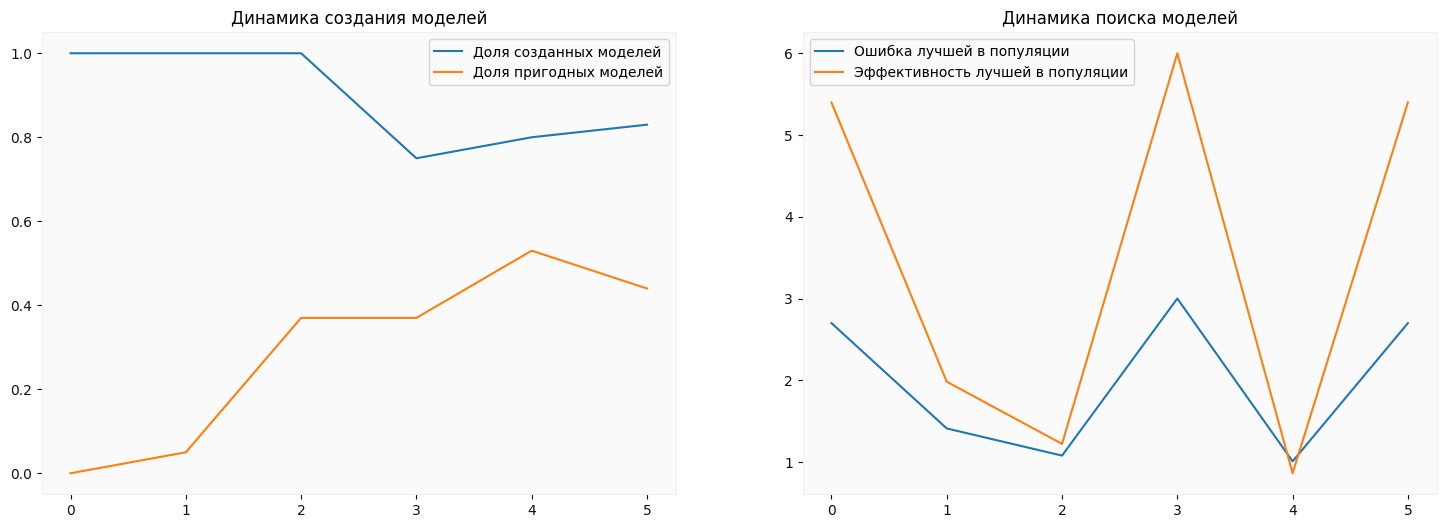

In [ ]:
import time
# ВЕРСИЯ КОДА С ПОСЕВОМ и генетикой в создании новых популяций

# Сохраняем массивы лучших моделей на диск
# [[[bot_pop_1],[blockov_list_1],[bot_1]],[[bot_pop_1],[blockov_list_1],[bot_1]]]
# куда  пишет данные этот код
directory = ''  

########### посев сетей вначале кода ############################################
posev = [] # смотри пояснения выше как передать сюда ранее созданные данные
# если еще нет список моделий, то ввести 0
# или можно вручную списки подать, указав вместо 0, сколько будкт сетей 
# последовательно в ответ ввести  листы [bot_pop], [blockov_list], [bot] 

# в текстовой ячейке ниже есть 2 сети для посева вручную

########### для подсевания лучших сетей прошлых эпох ###########################
waitnets = 3 # сколько выводим лучших для для изучения и посева
dw = 0.4 # доля лучших с прошлых эпох для подсева
frbest = 3 # как часто подсевыем лучших с прошлых эпох
################################################################################

########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]      

# функции активации для выходного слоя                  
activ_out = ['linear']
# словарь типов сетей
style_net = {0: 'Dense',
             1: 'Conv', 
             2: 'Recur',
             None: 'MIX'
}

################################################################################
q_tyblocks = 8    # макс количество генерируемых блоков для сети
q_lays = 10       # макс количество слоев в блоках
################################################################################
verbouse = 0      # выводить или нет точность по ходу обучения  
epohs = 10        # Количество эпох для поиска
################################################################################

################################################################################
n = 10            # количество ботов популяции 
p = 7             # количество популяций

dn = 0.3 # доля выживших ботов
dp = 0.3 # доля выживших популяций

dneff = 0.1 # доля выживших ботовию по эффективности
dpeff = 0.1 # доля выживших популяций
            # по эффективности

prb_randbot = 0.2 # вероятность появления случайного бота в новой популяции
mutp = 0.4   # Коэфициент мутаций при создании мегабота новой популяции
mutn = 0.45  # Коэфициент мутаций при создании бота новой сети в популяции

dpsurv = 0.8 # доля от выживших ботов популяции используемыех в родителях
dnsurv = 0.8 # доля от выживших ботов мегапопуляции используемыех в родителях
################################################################################


################################################################################

nsurv = max(2,round(dn* n))  # Кол-во выживших ботов мин 2 для родителей
psurv = max(2,round(dp * p)) # Кол-во выживших популяций 

nsurv_eff = max(1,round(dneff * n)) # Коли-во выживших ботов поп-ии по эффект.
psurv_eff = max(1,round(dpeff * p)) # Кол-во выживших ботов мегапоп по эффект.

nnew = max(0, n - nsurv - nsurv_eff)  # Кол-во новых ботов
pnew = max(0, p - psurv - psurv_eff)  # Кол-во новых популяций

parents_n = round(nsurv*dnsurv) # выж. боты популяции используемые в родителях 
parents_p = round(psurv*dpsurv) # выж. боты мегапопуляции используемые в родит. 

sevbest = round(waitnets*dw) # сколько подсеем лучших с прошлых эпох
################################################################################


################################################################################
popul = []         # обнулении популяции
val_p = []         # обнулении точности популяции
# создаем мегопопуляцию популяций ботов
mega_popul = []
mega_info = []
botpop_lst = []

start_time = time.time()

# для посева из определенных моделей нужно создвть лист сетей попримеру
# или ввести 0 при запросе input() 
if posev == []: posev = posev_net() 

for m in range(p):
############# ПОСЕВ ############################################################
    # сеем популяции из листа posev
    if posev != [] and m < len(posev):
        bot_pop = posev[m][0]
        blockov_list = posev[m][1]
        popul = []                 # Создаем пустую популяцию
        popul.append(posev[m][2])  # задаем первого бота популяции из сева
        for i in range(1,n):       # Проходим по всей длине популяции от 1
            # создаем оставшихся случайнонных ботов из сеяного blockov_list
            # определяем тип создания модели
            choosing_net = Set_net(bot_pop[2], activ_lays, activ_out, neiro_out)
            # инициализируем класс структуры блоков на основе парраметров сети
            maker_blocks = Make_blocks(choosing_net)
            bot = maker_blocks.buildblock_bot(blockov_list) 
            popul.append(bot)      # добавляем бота в популяцию
        
################################################################################          
    # генерируем бота популяции        
    else: # если нет посева или если посев менее нужного количества  
        # случайно выбираем тип популяции
        type_net = random.choice((None, 0, 1, 2))
        # инициализируем Set_net на основе заданных парамметров
        choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
        # инициализируем класс структуры блоков на основе парраметров сети
        maker_blocks = Make_blocks(choosing_net)
        bot_pop = maker_blocks.buildpopulbot(q_tyblocks, q_lays)

        # генерируем из состав блоков из к-ва блоков и слоев
        structure = [np.random.randint(0,bot_pop[1]) for i in range(bot_pop[0])] 
        # создаем единый список блоков для популяции
        blockov_list = maker_blocks.sostav_blockov(structure) 
        popul = []             # Создаем пустую популяцию
        for i in range(n):     # Проходим по всей длине популяции
            # создаем очередного случайнонного бота на основе blockov_list
            bot = maker_blocks.buildblock_bot(blockov_list) 
            popul.append(bot)  # добавляем бота в популяцию

    mega_popul.append(popul) # доб. популяцию в мегапопуляцию
    mega_info.append(blockov_list) # доб. информацию о блоках  в мегапопуляцию
    botpop_lst.append(bot_pop) # доб. мегабота популяции в лист ботов популяций
if posev != []: print(f'Посеено {len(posev)} сетей')

# счетчики
avl_mdl = 0 # счетчик созданных моделей
non_mdl = 0 # счетчик не созданных моделей
ntk_mdl = 0 # счетчик моделей не подходящих под задачу
gd_mdl  = 0 # счетчик моделей пригодных под задачу
################################################################################

################################################################################
# для сбора данных об эффективности обучения от эпохи
ephtime_lst = []
avlmdl_lst  = []
gdmdl_lst   = []
sval_lst    = []
seff_lst    = []
svalp_lst   = []
seffp_lst   = []
bestnets = []
val_best = []
################################################################################

# Пробегаемся по всем эпохам
for it in tqdm(range(epohs), unit ="epohs",  # Пробегаемся по всем эпохам
                   desc ="Пробегаемся по всем эпохам"):
    val_p = []
    eff_p = []
    curr_time = time.time()
    for m in tqdm(range(p), unit ="popul",
                desc ="Проходимся по популяциям"): # проходимся по популяциям
        popul = mega_popul[m]       # берем очередную популяцию 
        blockov_list = mega_info[m] # берем информацию и популяции 
        bot_pop = botpop_lst[m]     # берем очередного мегабота популяцию 
        val = []
        eff = [] #  список для списков по среднему обучению модели в fit()
        for i in range(n): # Проходим по всей длине популяции           
            bot = popul[i] # Берем очередного бота
        
            ########################################
            # определяем тип создания модели
            choosing_net = Set_net(bot_pop[2], activ_lays, activ_out, neiro_out)
            # инициализируем класс структуры блоков на основе парраметров сети
            maker_blocks = Make_blocks(choosing_net)
            # инициализируем класс формирования сети
            regress_model = WildregressModel(INSHAPE)
            # тип сети для отображения
            discription = style_net[bot_pop[2]]
            ###########################################

           #####################################################################
           #               ОЦЕНКА МОДЕЛИ ОТ БОТА ПОПУЛЯЦИИ                     #
           #####################################################################
            try:
              # пробуем создать модель
              gen_model = regress_model(bot_pop,      # бот_популяции сетей 
                                        bot,          # бот парам-в слоев сети 
                                        blockov_list, # список имен слоев сети  
                                        maker_blocks, # класс построения блоков
                                        # парамметр от декаратора
                                        timeout = TIMELIMIT_1, 
                                        # время в сек отводимое на оценку
                                        )
              # если превысили время, то gen_model - просто сообщение
              if type(gen_model) == str:
                  print(gen_model)
                  testing = False
              else: # значит модель создалась
                  print(discription + ' - создалась')
                  testing = True
                  avl_mdl+=1

              # Вычисляем точность текущего бота
              try:
                  if testing:
                      # оптимизатор
                      optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
                      # функция потерь
                      loss = tf.keras.losses.MSE
                      # оценка по времени и смешанной точности нашей модели
                      result = evaluate_model(
                      # парамметр от декаратора
                      timeout =  TIMELIMIT_2,  # время в сек отводимое на оценку
                      # собственные парамметры функции
                      model = gen_model,           # тестируемая модель
                      y_scaler = Y_SCAILER,        # обученный скейлер для y
                      train_gen = train_datagen,   # генератор данных для обучения
                      val_gen = val_datagen,       # генератор данных для проверки
                      ep = 5,                      # эпох обучения
                      verb = verbouse,             # отображать ли обучение
                      optimizer = optimizer,       # оптимизатор
                      loss = loss,                 # функция потерь
                      channels = np.arange(PREDICT_LAG),# Отображение сводки модели
                      predict_lag = PREDICT_LAG)   # На сколько шагов предсказание
                      
                      # выводим результат оценки   
                      # если превысили время, то gen_model - просто сообщение             
                      if len(result) > 2:
                        print(result)
                        ntk_mdl+=1
                        f = 500
                        tlrn = 500    
                      else: # значит модель протестировалась
                        f = result[0]
                        tlrn = result[1]                                         
                        print(discription + ' - подошла под задачу')
                        gd_mdl+=1

                  else:
                    print(discription + ' - слишком долго создавалась')
                    print()
                    ntk_mdl+=1
                    f = 600
                    tlrn = 600 
                    print()  

              except Exception:
              # если не создалась то пишем плохую точность
                  print(discription + ' - не подошла под задачу')
                  print()
                  ntk_mdl+=1
                  f = 800
                  lrn = 800

            except Exception:
                # если не создалась то пишем плохую точность
                print(discription + ' - не создалась')
                print()
                non_mdl+=1 
                f = 1000
                tlrn = 1000
            print(f'Оценка модели {f} и время {tlrn}')    
               
            val.append(f)       # Добавляем полученное значение в список val
            eff.append(tlrn*f) # сохраняем время эффективность обучения модели 
           #####################################################################

        ########################################################################
        # Сортируем val
        sval = sorted(val, reverse=0) 
        val_p.append(sval)
        #для сбора динамики точности от популяции
        sval_lst.append(np.log10(sval[0])) 

        # Сортируем по эффективности
        seff = sorted(eff, reverse=0) 
        eff_p.append(seff)
        # для сбора динамики эффективности от популяции
        seff_lst.append(np.log10(seff[0])) 
        ########################################################################

        clear_output()
        ########################################################################
        # сбор|вывод данных эффективности поиска от популяции к популяции
        try:
            avlmdl = round(avl_mdl/(avl_mdl+non_mdl),2)
            avlmdl_lst.append(avlmdl)
            nonmdl = round(non_mdl/(avl_mdl+non_mdl),2)
            gdmdl = round(gd_mdl/(avl_mdl),2)
            gdmdl_lst.append(gdmdl)
            ntkmdl = round(ntk_mdl/(avl_mdl),2)
            # Показываем ход генитеческого поиска
            show_pocess_1(avlmdl_lst, gdmdl_lst, sval_lst, seff_lst)       
            print()
            print(f'Мегапопуляция {m}, эпоха {it+1}')
            print(f'Модели популяции: создано {[avl_mdl,avlmdl]} брак {[non_mdl,nonmdl]}')
            print(f'Модели популяции: пригодны {[gd_mdl,gdmdl]} не пригодны {[ntk_mdl,ntkmdl]}')
        except:
            pass

    ############################################################################
    # сбор и вывод данных для оценки эффективности поиска от эпохи
    # сорт. список точностей мегапопуляции отсортированые точностями популяций
    sval_p = sorted(val_p, key=lambda x: x[0]) 
    # сортируем список точностей мегапопуляции по эффективности
    seff_p = sorted(eff_p, key=lambda x: x[0]) 
    eph_time = time.time() - curr_time
    # собираем для контроля поиска и отображения
    svalp_lst.append(np.log10(sval_p[0][0]))
    seffp_lst.append(np.log10(seff_p[0][0]))      
    ephtime_lst.append(eph_time)

    ############################################################################
    # Показываем ход генитеческого поиска
    if it > 1: show_process_2(svalp_lst, seffp_lst, ephtime_lst)

    # Показыааем результаты лучших ботов
    acc_models = np.array(sval_p)[:4,:4]
    eff_models = np.array(seff_p)[:4,:4]
    to_end = round(np.mean(ephtime_lst)*(epohs-it-1))
    print(f'Эпоха {it}, точность моделей {acc_models}')
    print(f'Время на эпоху {eph_time}, эффективность моделей {eff_models}')
    print(f'До окончания поиска {to_end} сек.')
    ############################################################################

    ########## пересохраняем каждую эпоху данные ###############################
    saver([mega_popul, botpop_lst, mega_info, svalp_lst, ephtime_lst], directory)
    # это можно взять в свернутый лист автопосев на случай сбоя колаба
    # то возобновить код с момента создания новых мега популяций и популяций
    ############################################################################

    ############################################################################
    #   ФОРМИРОВАНИЕ НОВЫХ ПОПУЛЯЦИЙ НА ОСНОВЕ ПОЛУЧЕННЫХ ОЦЕНОК               #
    ############################################################################
    newmega_popul = []        
    newmega_info  = []
    newbotpop_lst = []
    newtime_mega  = [] 
    # записываем данные лучших по точночти сетей
    for m in range(psurv): # проходимся по выжившим мега-популяциям
        idx_p = val_p.index(sval_p[m])  # индекс из списка лучших 
        newmega_popul.append(mega_popul[idx_p])    
        newmega_info.append(mega_info[idx_p])    
        newbotpop_lst.append(botpop_lst[idx_p])  
        
    # записываем эффективных  ботов популяций
    for m in range(psurv_eff): #
        idx_p = eff_p.index(seff_p[m])  # индекс из списка эффективных
        newmega_popul.append(mega_popul[idx_p])     
        newmega_info.append(mega_info[idx_p])    
        newbotpop_lst.append(botpop_lst[idx_p])  

    # идем по отобранным популяциям точных и эффективных
    for m in range(psurv+psurv_eff): 
        newpopul = []                
        newtime_pop= []
        popul = newmega_popul[m]
        blockov_list = newmega_info[m]
        bot_pop = newbotpop_lst[m]

        # записываем отобранных ботов в популяции
        for i in range(nsurv):   
            idx = val.index(sval[i])  # индекс бота лучших в списке val
            newpopul.append(popul[idx])  
        # записываем эффективных ботов в популяци
        for i in range(nsurv_eff): 
            idx = eff.index(seff[i]) # индекс бота эффекивных в списке val         
            newpopul.append(popul[idx])       

        # берем ген определяющий тип сети популяции
        type_net = bot_pop[2]
        choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
        ## инициализируем класс структуры блоков на основе параметров сети
        maker_blocks = Make_blocks(choosing_net)
        bots_random = [maker_blocks.buildblock_bot(blockov_list) \
                       for i in range(nnew)]
        # Проходимся в цикле nnew-раз
        for i in range(nnew):                  
            idxp =  np.random.randint(0, nsurv + nsurv_eff, parents_n)
            bots_parent = [newpopul[i] for i in idxp]

            newbot = []  # Создаем пустой список под значения нового бота            
            # Пробегаем по всей длине бота 
            for j in range(len(blockov_list)):                         
              k = np.random.randint(0, parents_n) 
              x = bots_parent[k][j]
   
              # С вероятностью mutn устанавливаем значение бота
              if (np.random.random() < mutn):
                k = np.random.randint(0, nnew)
                x = bots_random[k][j]
                
              newbot.append(x)      # Доб. очередное значение в нового бота      
            newpopul.append(newbot) # Доб. бота в новую популяцию  
        # Собираем популяцию
        popul = newpopul       
        newmega_popul.append(popul)
        newmega_info.append(blockov_list)
        newbotpop_lst.append(bot_pop)

        ########## пересохраняем каждую эпоху данные ###########################
        saver([newmega_popul, newbotpop_lst, newmega_info], directory)
        # это можно взять в свернутый лист автопосев на случай сбоя колаба
        # то возобновить код с момента создания новых мега популяций и популяций
        ########################################################################
    
    ##################### ПОДСКАЗКА ДЛЯ УЛУЧШЕНИЯ ##############################
    # Можно тут организовать тригер, чтобы имея сохраненными newmega_popul, 
    # newbotpop_lst, newmega_info на диске, запускать цихл не вначале, а с этого 
    # момента, загрузив вначале их в код.
    ############################################################################

    ########### Сортировка и сохранение лушх сетей #############################
    # получаем индексы  лучших сетей по всем мегапопуляциям
    idxs, sval_best = get_idxbest(sval_p, waitnets)
    # получаем спиок лучших сетей по всем мегапопуляциям на эпохе
    newbestnets = get_bestnets(idxs, newbotpop_lst, newmega_info, newmega_popul)
    for i in range(waitnets):
        bestnets.append(newbestnets[i])
    # объединяем списки
    val_best = np.hstack((val_best,sval_best))
    idx = np.argsort(val_best)[:waitnets] # получаем индексы для сортировки
    val_best = val_best[idx]
    bestnets = [bestnets[i] for i in idx]
    np.save(directory + 'bestnets.npy', bestnets)
    ############################################################################

    ############# ПОДСЕВ лучшх сетей с прошлых эпох ############################
    if (it > 1 and  it % frbest == 0) and (p - psurv - psurv_eff - sevbest) > 0:
        pbest = sevbest
        posev_lst = bestnets[:pbest]
        # сеем популяции из листа posev
        for m in range(pbest): 
            bot_pop = posev_lst[m][0]
            blockov_list = posev_lst[m][1]
            popul = []                 # Создаем пустую популяцию
            # задаем первого бота популяции из сева
            popul.append(posev_lst[m][2]) 
            # Проходим по всей длине популяции от 1
            for i in range(1,n):  
                # берем ген определяющий тип сети популяции
                type_net = bot_pop[2]    
                choosing_net = Set_net(type_net, activ_lays, activ_out, 
                                       neiro_out)
                # иници/ класс структуры блоков на основе парраметров сети
                maker_blocks = Make_blocks(choosing_net)
                # создаем оставшихся случайнонных ботов из сеяного blockov_list
                bot = maker_blocks.buildblock_bot(blockov_list) 
                popul.append(bot)      # добавляем бота в популяцию
            # добавляем популяцию в мегапопуляцию
            newmega_popul.append(popul) 
            # добавляем информацию о блоках  в мегапопуляцию
            newmega_info.append(blockov_list) 
            # добавляем мегабота популяции в лист ботов популяций
            newbotpop_lst.append(bot_pop)
        print(f'Посеено {len(posev_lst)} сетей из лучших прошлых эпох')     
    else:
        pbest = 0

    ############################################################################
    #     создаем новых ботов новых популяций основе скрещиваний и мутаций     #
    ############################################################################
    pneweph = pnew - pbest # сколько  создаем новых популяций от родителей
    # случайно выбираем тип сети
    type_net = random.choice((None, 0, 1, 2))
    # создаем новых ботов в эту популяцию
    choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
    # инициализируем класс структуры блоков на основе парраметров сети
    maker_blocks = Make_blocks(choosing_net)
    bots_poprandom = [maker_blocks.buildpopulbot(q_tyblocks, q_lays) \
                      for i in range(pnew - pbest)]
    # создаем популяции от родителей 
    for m in range(pneweph):
        idxp =  np.random.randint(0, psurv + psurv_eff, parents_p)
        bots_popparent = [newbotpop_lst[i] for i in idxp]
        # Создаем пустой список под значения нового мегабота
        newbot_pop = []                   
        # Получаем случайное число в диапазоне от 0 до 1        
        if np.random.random() < prb_randbot:
            k = np.random.randint(0, pneweph) 
            bot_pop = bots_poprandom[k]  # берем совсем случайный бот пупуляции

        else:  # создаем бот пупуляции генетикой 
            # Пробегаем по всей длине бота 
            for j in range(len(bots_poprandom[0])):         
                  k = np.random.random_integers(0, parents_p-1)  
                  x = bots_popparent[k][j]

                  # С вер. mutp ставим значение бота из случайного мегабота
                  if np.random.random() < mutp:
                      k = np.random.randint(0, pneweph)
                      x = bots_poprandom[k][j]
                  newbot_pop.append(x)  # Доб. ген в нового мегабота            
            bot_pop = newbot_pop        # бот популяции создан

        # генерируем из состав блоков популяции
        structure  = [np.random.randint(0, bot_pop[1]) for i in \
                      range(bot_pop[0])]
        # случайно выбираем тип сети
        type_net = random.choice((None, 0, 1, 2))
        choosing_net = Set_net(type_net, activ_lays, activ_out, neiro_out)
        # инициализируем класс структуры блоков на основе парраметров сети
        maker_blocks = Make_blocks(choosing_net)
        # создаем единый список блоков для популяции
        blockov_list = maker_blocks.sostav_blockov(structure)  

        popul = [] # Создаем пустую популяцию
        # Проходим по всей длине популяции
        for i in range(n):     
            # создаем очередного случайнонного бота на основе blockov_list
            bot = maker_blocks.buildblock_bot(blockov_list) 
            popul.append(bot)  # доб. бота в популяцию
        newmega_popul.append(popul) # доб. популяцию в мегапопуляцию
        newmega_info.append(blockov_list) # доб. информацию о блоках
        newbotpop_lst.append(bot_pop) # доб. мегабота

    # перезаписываем информацию    
    mega_popul = newmega_popul
    mega_info = newmega_info
    botpop_lst = newbotpop_lst
    ############################

    ########## пересохраняем каждую эпоху данные ###############################
    saver([mega_popul, botpop_lst, mega_info, svalp_lst], directory)
    # это можно взять в свернутый лист автопосев на случай сбоя колаба
    # то возобновить код с момента создания новых мега популяций и популяций
    ############################################################################

finish_time = time.time() - start_time
print(f'Общее время подбора за {epohs} эпох по {p*n} моделей составило {finish_time}')

ПРИМЕР ДЛЯ ПОСЕВА ВРУЧНУЮ:

    # вариант из презентации
    bot_pop = [7, 1, None, 1, 16, 7, 0, 0, 0, 0]
    setblockov = [[], [], ['Conv1DT'], ['Dense'], [], [], []]
    bot = [[], [], [64, 4], [128], [], [], []]

    # иной вариант
    bot_pop = [4, 1, None, 1, 128, 6, 0, 0, 0, 0]
    setblockov = [[], ['Lstm'], ['Conv1D_dilation_block'], []]
    bot = [[], [4], [8, 2], []]

# После генетики

## Генерация нейронки

In [ ]:
directory =''  # куда пишет данные код
########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]      

# функции активации для выходного слоя                  
activ_out = ['linear']

# загружаем список парамметров лучших сетей 
save_nets = np.load(directory+'bestnets.npy', allow_pickle = True)

# генерируем список моделей в количестве n 
set_models = getnetfrombest(save_nets, activ_lays,
                            activ_out, neiro_out,
                            limit = TIMELIMIT_1,
                            n = 3)


In [ ]:
k = 0 # указываем индекс от 0 до n-1 для выбора модели
good_model = set_models[k]
good_model.call = tf.function(good_model.call)

# Отображение сводки модели
good_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 29, 54)]     0           []                               
                                                                                                  
 conv1d_transpose_2 (Conv1DTran  (None, 29, 32)      8672        ['input_2[0][0]']                
 spose)                                                                                           
                                                                                                  
 conv1d_transpose_3 (Conv1DTran  (None, 29, 32)      5152        ['conv1d_transpose_2[0][0]']     
 spose)                                                                                           
                                                                                            

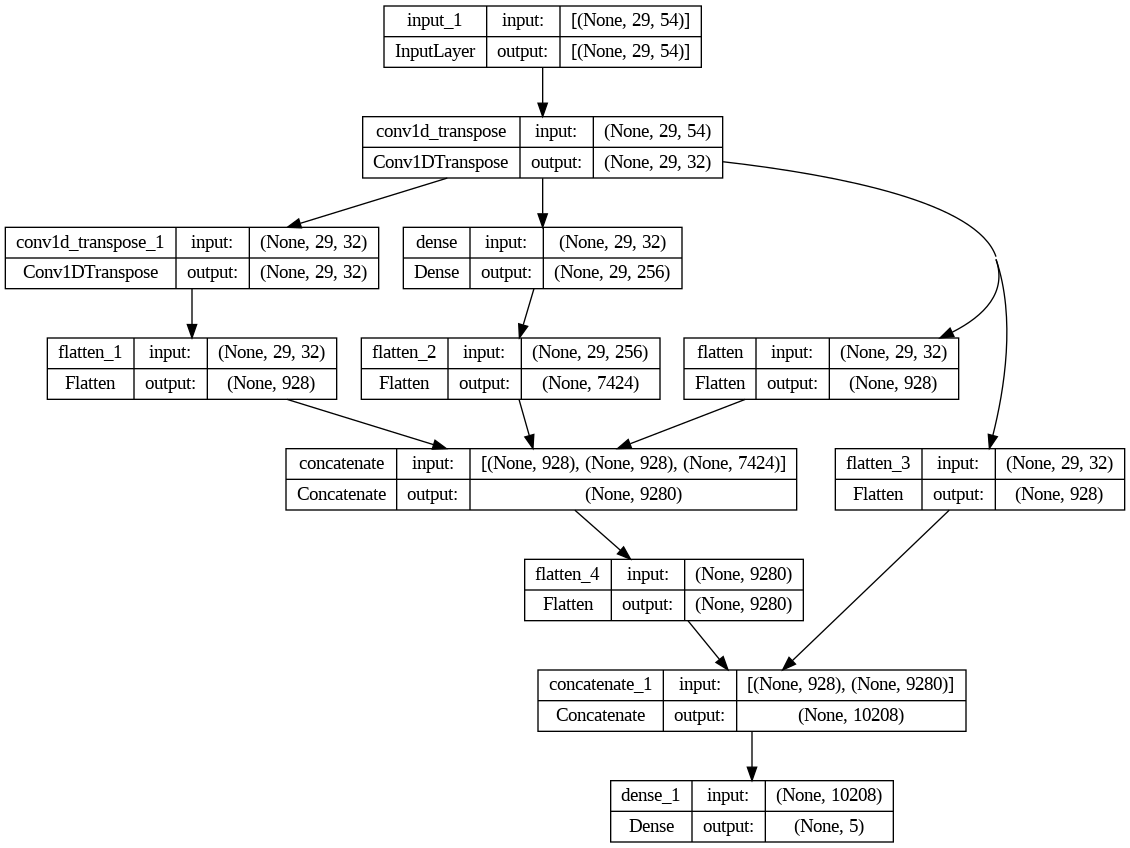

In [ ]:
# дерево модели
tf.keras.utils.plot_model(good_model, show_shapes=True)

## Обучение сгенерированной модели

In [33]:
from time import time
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

# очистка ОЗУ 
clear_ozu = GarbageCollectorCallback()

### Вариант 1 - Базавое как в лекции

In [34]:
# оптимизатор
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.Huber() # MSE #
good_model.compile(optimizer = optimizer, loss = loss)

# понижение шага 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8, 
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=17,
    mode='min',
    restore_best_weights=True)

NameError: ignored

In [ ]:
start = time()
# обучение модели вашей
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 150,
                          callbacks=[early_stopping, reduce_lr, clear_ozu],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/150
112/112 [==============================] - 2s 9ms/step - loss: 0.0469 - val_loss: 0.0032 - lr: 0.0010
Epoch 2/150
112/112 [==============================] - 1s 7ms/step - loss: 0.0076 - val_loss: 0.0015 - lr: 0.0010
Epoch 3/150
112/112 [==============================] - 1s 6ms/step - loss: 0.0063 - val_loss: 0.0304 - lr: 0.0010
Epoch 4/150
112/112 [==============================] - 1s 7ms/step - loss: 0.0102 - val_loss: 0.0013 - lr: 0.0010
Epoch 5/150
112/112 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0022 - lr: 0.0010
Epoch 6/150
112/112 [==============================] - 1s 6ms/step - loss: 0.0022 - val_loss: 0.0022 - lr: 0.0010
Epoch 7/150
104/112 [==========================>...] - ETA: 0s - loss: 0.0042
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
112/112 [==============================] - 1s 6ms/step - loss: 0.0040 - val_loss: 0.0015 - lr: 0.0010
Epoch 8/150
112/112 [==============================] - 1s 7ms

### Вариант 2 - используя CyclicalLearningRate и SGD

In [ ]:
# дополнительная библиотека tensorflow_addons
!pip install -q -U tensorflow_addons

import tensorflow_addons as tfa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.9 MB/s eta 0:00:00


In [ ]:
INIT_LR = 1e-3
MAX_LR = 1e-2

steps_per_epoch = len(x_train) // BATCH_SIZE

# понижение шага циклами
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
# оптимизатор
optimizer = tf.keras.optimizers.SGD(clr)

# функция потерь
loss = tf.keras.losses.Huber() #MSE # 
good_model.compile(optimizer = optimizer, loss = loss)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience= 55,
    mode='min',
    restore_best_weights=True)

In [ ]:
start = time()
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 150,
                          callbacks=[early_stopping, clear_ozu],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/150
112/112 [==============================] - 2s 9ms/step - loss: 5.2797e-04 - val_loss: 1.9090e-04
Epoch 2/150
112/112 [==============================] - 1s 8ms/step - loss: 5.0095e-04 - val_loss: 2.7184e-04
Epoch 3/150
112/112 [==============================] - 1s 10ms/step - loss: 4.8560e-04 - val_loss: 2.1551e-04
Epoch 4/150
112/112 [==============================] - 1s 10ms/step - loss: 4.8239e-04 - val_loss: 2.5862e-04
Epoch 5/150
112/112 [==============================] - 1s 10ms/step - loss: 4.7435e-04 - val_loss: 2.5528e-04
Epoch 6/150
112/112 [==============================] - 1s 7ms/step - loss: 4.8209e-04 - val_loss: 2.6440e-04
Epoch 7/150
112/112 [==============================] - 1s 7ms/step - loss: 4.8256e-04 - val_loss: 3.1055e-04
Epoch 8/150
112/112 [==============================] - 1s 7ms/step - loss: 4.7858e-04 - val_loss: 2.8659e-04
Epoch 9/150
112/112 [==============================] - 1s 7ms/step - loss: 4.7253e-04 - val_loss: 3.0603e-04
Epoch 10/150
112

### Вариант 3 - используя взвешанное MSE
пример https://towardsdatascience.com/how-to-create-a-custom-loss-function-keras-3a89156ec69b

In [ ]:
len_period = PREDICT_LAG

weights = []
for i in range(len_period):
  w = (len_period-i)/len_period
  weights.append(w)

weights

[1.0, 0.8, 0.6, 0.4, 0.2]

In [ ]:
def weight_mse(w):

    def custom_mse(y_true, y_pred, w = w):  
        # разница target и predicted
        loss = tf.keras.backend.square(y_pred - y_true)  # (batch_size, 2)

        # умножаем на веса
        loss*= w         # (batch_size, 2)
                    
        # усредняем ошибку 
        loss = tf.keras.backend.mean(loss, axis=-1)        # (batch_size,)     
        return loss
    return custom_mse

In [ ]:
import tensorflow_addons as tfa
INIT_LR = 1e-4
MAX_LR = 1e-3

steps_per_epoch = len(x_train) // BATCH_SIZE

# понижение шага циклами
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
)
# оптимизатор
optimizer = tf.keras.optimizers.SGD(clr)
# функция потерь
loss = weight_mse(weights)
good_model.compile(optimizer = optimizer, loss = loss)

# понижение шага 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8, 
                                                 patience = 3,
                                                 min_lr = 1e-9, verbose = 1)
# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience= 55,
    mode='min',
    restore_best_weights=True)

In [ ]:
start = time()
history = good_model.fit(train_datagen,                  # генератор данных для обучения
                          validation_data = val_datagen, # генератор данных для проверки
                          epochs = 200,
                          callbacks=[early_stopping, clear_ozu],
                          verbose = 1)

end = time()
print(f'Время обучения {end:.5f} сек.')

Epoch 1/200
112/112 [==============================] - 2s 9ms/step - loss: 5.6798e-04 - val_loss: 2.5065e-04
Epoch 2/200
112/112 [==============================] - 1s 10ms/step - loss: 5.6204e-04 - val_loss: 2.7911e-04
Epoch 3/200
112/112 [==============================] - 1s 11ms/step - loss: 5.5881e-04 - val_loss: 2.9049e-04
Epoch 4/200
112/112 [==============================] - 1s 10ms/step - loss: 5.5546e-04 - val_loss: 3.0101e-04
Epoch 5/200
112/112 [==============================] - 1s 7ms/step - loss: 5.5351e-04 - val_loss: 2.9773e-04
Epoch 6/200
112/112 [==============================] - 1s 7ms/step - loss: 5.5493e-04 - val_loss: 3.0622e-04
Epoch 7/200
112/112 [==============================] - 1s 7ms/step - loss: 5.5500e-04 - val_loss: 3.0714e-04
Epoch 8/200
112/112 [==============================] - 1s 7ms/step - loss: 5.5381e-04 - val_loss: 3.0915e-04
Epoch 9/200
112/112 [==============================] - 1s 7ms/step - loss: 5.5258e-04 - val_loss: 3.0553e-04
Epoch 10/200
112

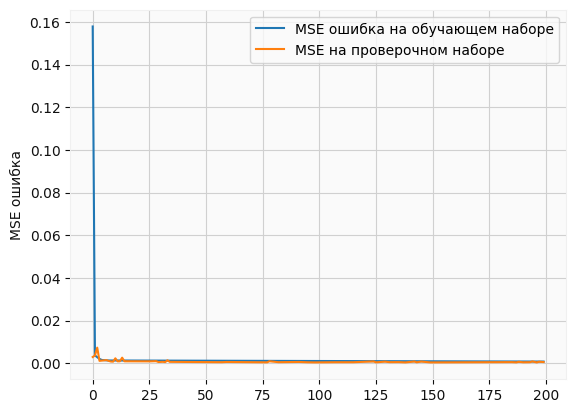

In [ ]:
plt.plot(history.history['loss'], 
         label='MSE ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='MSE на проверочном наборе')
plt.ylabel('MSE ошибка')
plt.legend()
plt.show()

## Оценка модели на VAL данных

14/14 [==============================] - 0s 2ms/step


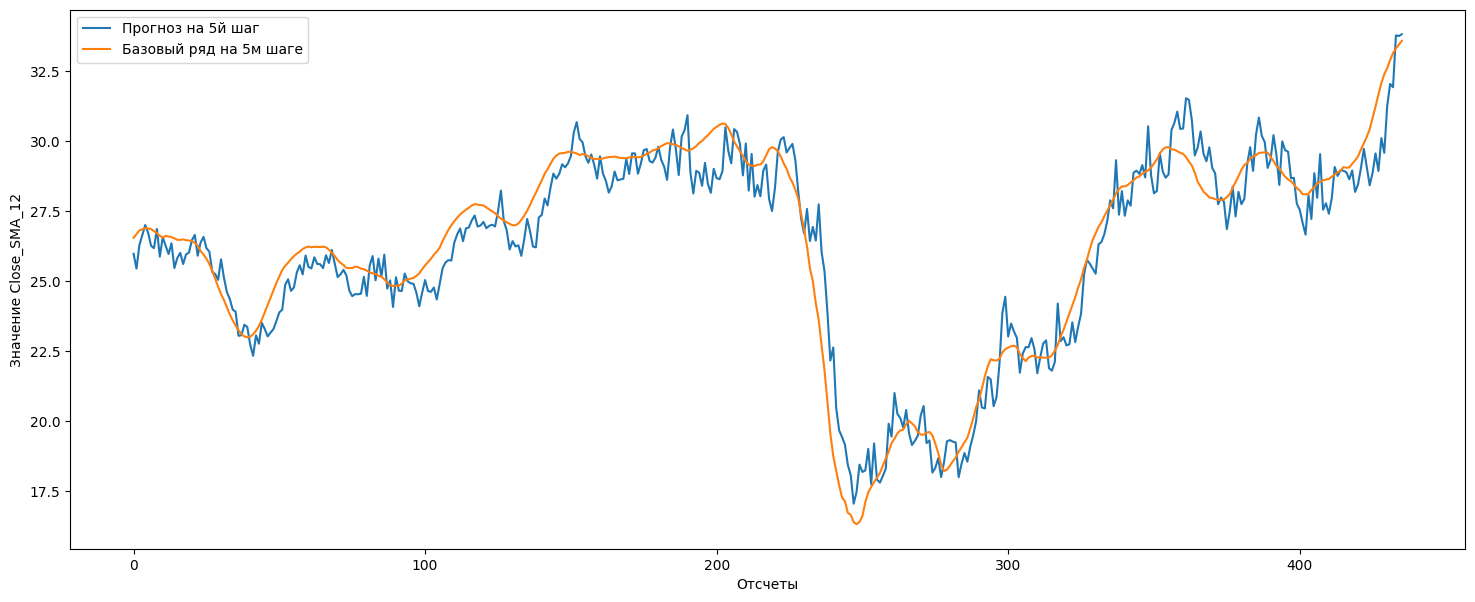

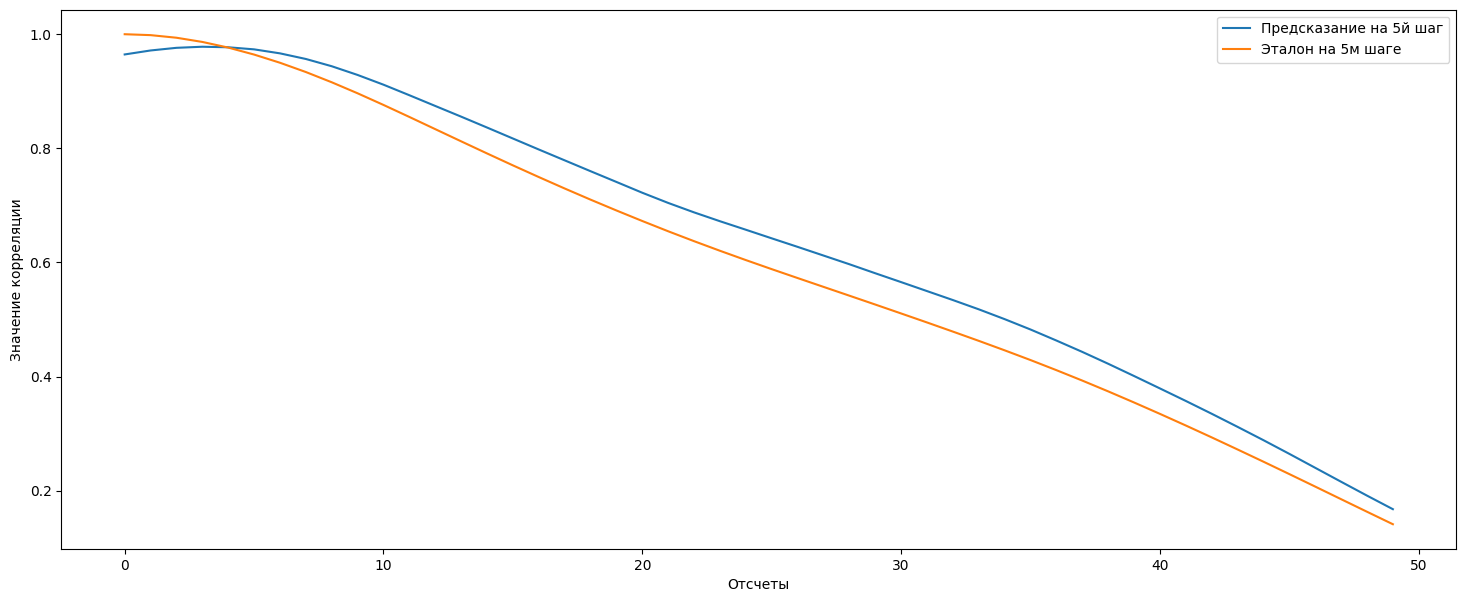

In [ ]:
# Прогнозируем данные текущей сетью
(y_pred_val, y_true_val) = get_scalepred(good_model, XVAL, YVAL, Y_SCAILER) #Прогнозируем данные
 
# Отображаем графики
show_predict(0,                    # начало периода
             y_true_val.shape[0],  # конец периода
             [4],                  # по предсказанию на какие шаги отрисовываем
             y_pred_val,           # предчказанные цены
             y_true_val,           # реальные цены
             PRED_PRICE,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([4],             # по предсказанию на какие шаги отрисовываем корреляцию
          50,     # на сколько шагов предсказание
          y_pred_val,      # предчказанные цены
          y_true_val       # реальные цены
          )

## Тест модели на TEST данных

### Готовим данные из df_test

In [ ]:
# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
x_test = X_SCAILER.transform(df_test[TRAIN_COLUMNS][: - PREDICT_LAG + 1])
print(x_test.shape)
# Для подготовки y_test на PREDICT_LAG шагов вперед необходимо создать дополнительный датасет
y_test = future_sequence(df_test[PRED_PRICE], PREDICT_LAG)

# если берем логорифм
if MAKE_LOG:
  y_test = np.log(y_test)
print(y_test.shape)

# Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
y_test = Y_SCAILER.transform(y_test)
print(y_test.shape)

(496, 54)
(496, 5)
(496, 5)


In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки/оценки
TestDataGen = TSG(x_test, y_test,        # В качестве параметров наши выборки
              length = DEPTH,            # Анализируем по 21 прошедшим точкам 
              sampling_rate = 1,         # Для каждой точки
              batch_size = len(x_test))  # Размер batch будет равен длине нашей выборки

XTEST, YTEST = [], []
for i in TestDataGen:
  XTEST.append(i[0])
  YTEST.append(i[1])

XTEST = np.array(XTEST)[0]
YTEST = np.array(YTEST)[0]
print(XTEST.shape,YTEST.shape)

(467, 29, 54) (467, 5)


### Делаем оценку test данных

15/15 [==============================] - 0s 5ms/step


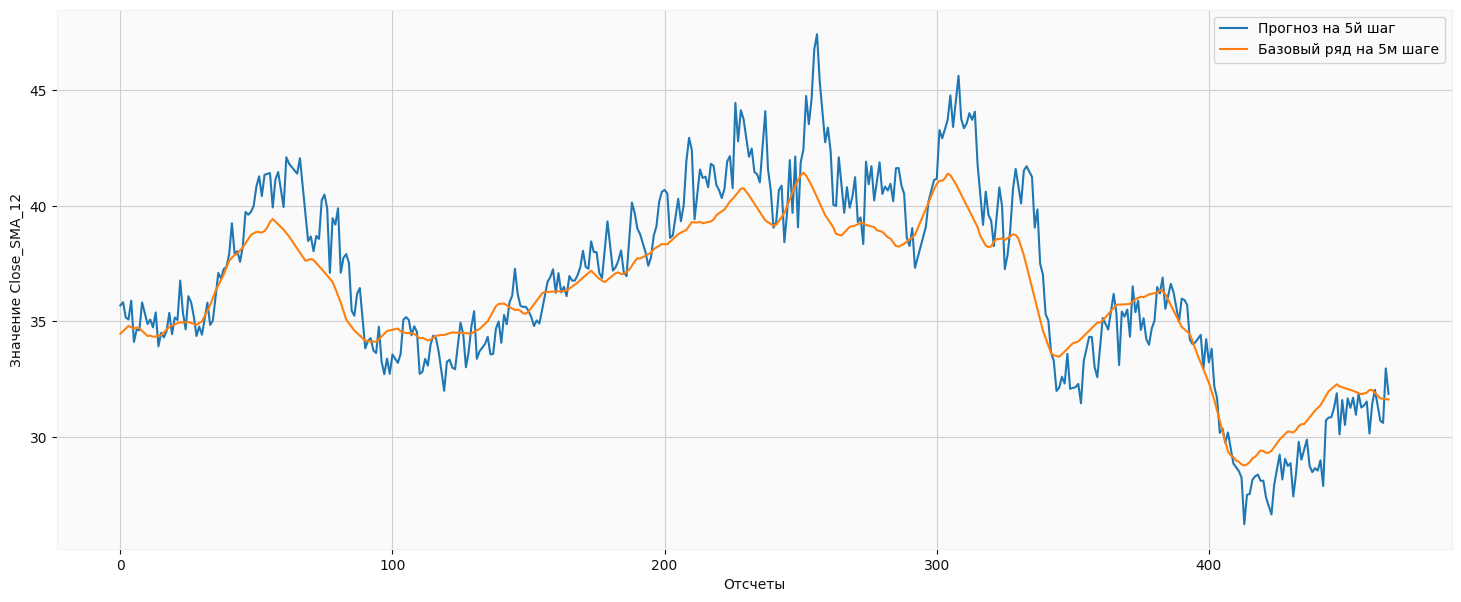

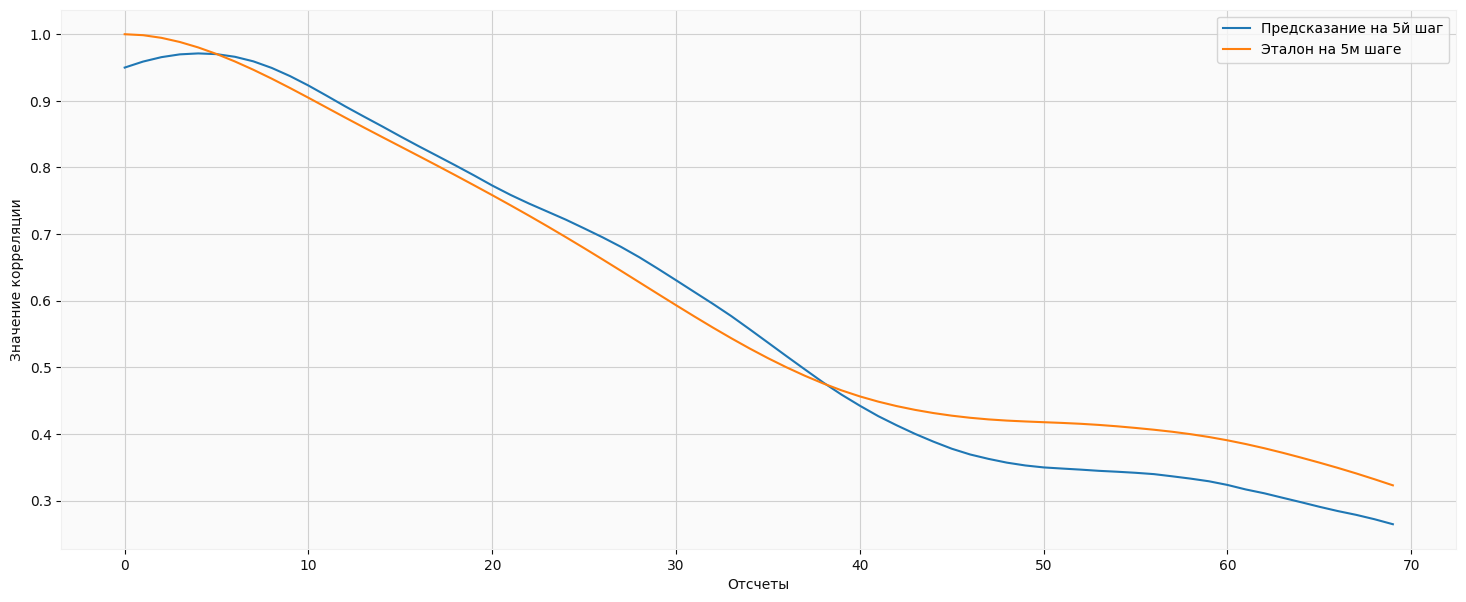

In [ ]:
# Прогнозируем данные текущей сетью
(y_pred_test, y_true_test) = get_scalepred(good_model, XTEST, YTEST, 
                                           Y_SCAILER) # Прогнозируем данные

 
# Отображаем графики
show_predict(0,                     # начало периода
             y_true_test.shape[0],  # конец периода
             [4],                   # по предсказанию на какие шаги отрисовываем
             y_pred_test,           # предчказанные цены
             y_true_test,           # реальные цены
             PRED_PRICE,
             figsize=(18,7))

# Отображаем корреляцию
# Проверяем корреляцию на глубину PREDICT_LAG шагов
auto_corr([4],              # по предсказанию на какие шаги отрисовываем корреляцию
          70,               # на сколько шагов предсказание
          y_pred_test,      # предчказанные цены
          y_true_test       # реальные цены
          )

### Смотрим цены и предсказываемое SMA_14

некоторые ссылки, что погли отрисовать:
- https://medium.com/@chris_42047/discover-the-awesome-power-of-mplfinance-python-tutorial-ea756975c77c
- https://github.com/matplotlib/mplfinance/issues/181
- https://stackoverflow.com/questions/70805395/how-do-i-set-the-tick-and-label-colours-in-mplfinance

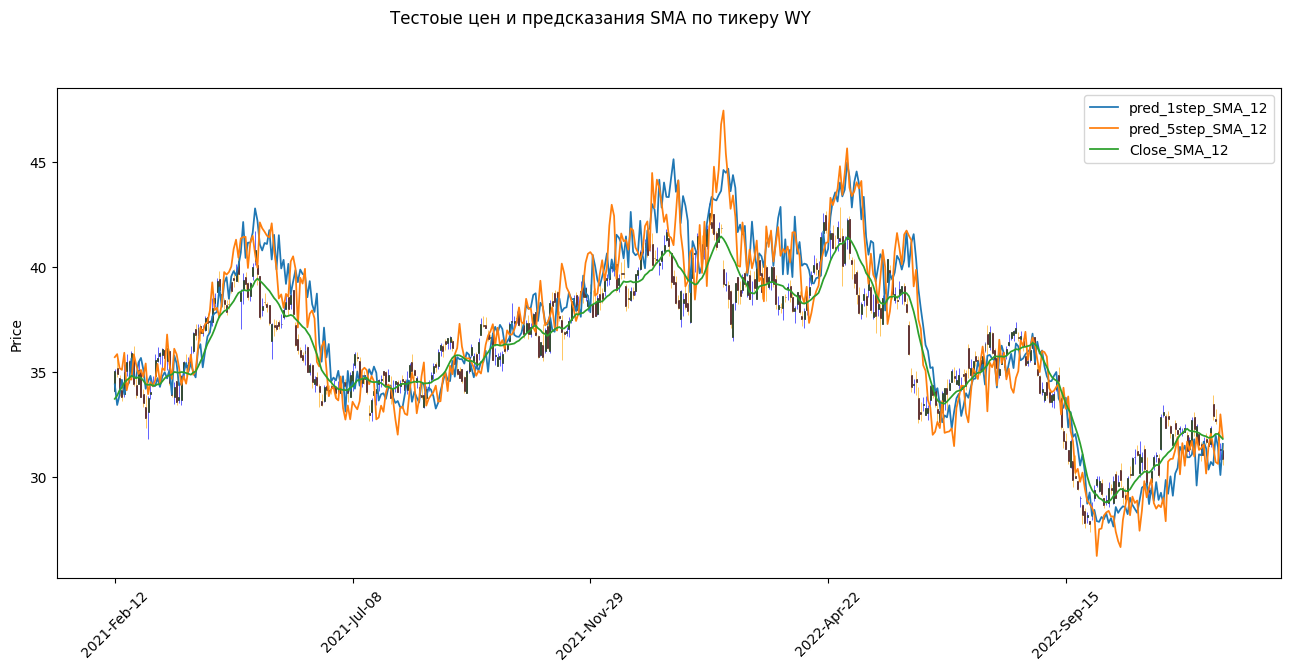

In [ ]:
# индексы шагов вперед
step_1 = 0
step_2 = 4

# добавленые графики и названия их
add_pls = {
    f'pred_{step_1+1}step_SMA_{WIND_SMA}' : mpf.make_addplot(y_pred_test[:, step_1]),
    f'pred_{step_2+1}step_SMA_{WIND_SMA}' : mpf.make_addplot(y_pred_test[:, step_2]),
    f'{use_column}_SMA_{WIND_SMA}': mpf.make_addplot(df_test[DEPTH: - PREDICT_LAG + 1][PRED_PRICE])
}

# название всего графика
title = f'Тестоые цен и предсказания SMA по тикеру {tiker}'

# стиль отрисовки
market_colors = mpf.make_marketcolors(
                               up='green',
                               down='red',
                               edge='black',
                               wick={'up': 'blue', 'down': 'orange'},
                               volume='gray',
                               ohlc='black')
my_style = mpf.make_mpf_style(marketcolors=market_colors)

# отрисовываем графиков
fig, ax = mpf.plot(df_test[DEPTH: - PREDICT_LAG + 1], # датафрейм
                    addplot= list(add_pls.values()),  # добавленые графики
                    style = my_style,  # в созданном стиле вывод
                    type='candle',     # тип свечи
                    figsize=(17, 7),   # figsize
                    title=title,       # название всего графика
                    returnfig=True)    # вывод fig, ax

# выводим легенды
ax[0].legend([None]*(len(add_pls)+2))
handles = ax[0].get_legend().legendHandles
ax[0].legend(handles=handles[2:],labels=list(add_pls.keys()))
plt.show()

### Смотрим фрагмент

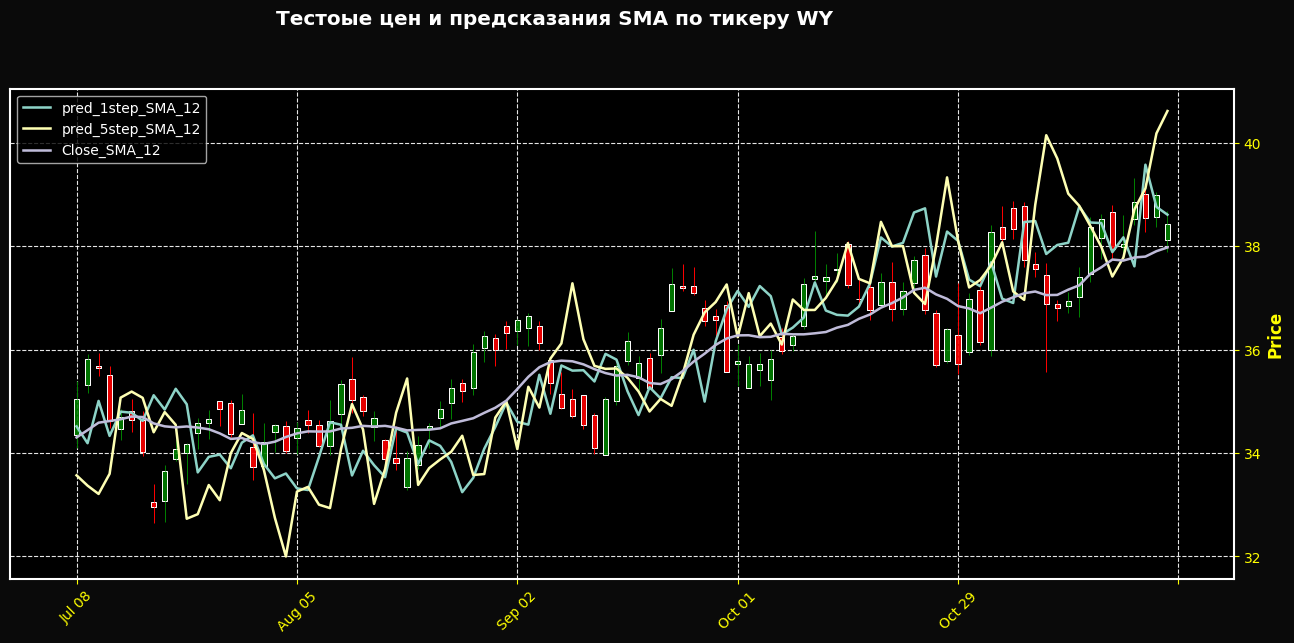

In [ ]:
# временной фрагмент
start = 100
end = 200

# индексы шагов вперед
step_1 = 0
step_2 = 4
# добавленые графики и названия их
add_pls = {
    f'pred_{step_1+1}step_SMA_{WIND_SMA}' : mpf.make_addplot(y_pred_test[:, step_1][start: end]),
    f'pred_{step_2+1}step_SMA_{WIND_SMA}' : mpf.make_addplot(y_pred_test[:, step_2][start: end]),
    f'{use_column}_SMA_{WIND_SMA}': mpf.make_addplot(df_test[DEPTH: - PREDICT_LAG + 1][PRED_PRICE][start: end])
}

# название всего графика
title = f'Тестоые цен и предсказания SMA по тикеру {tiker}'

my_style = mpf.make_mpf_style(base_mpf_style='mike',
                              base_mpl_style='dark_background',
                              marketcolors=mpf.make_marketcolors(up='g',down='r',
                                                                 edge='white',
                                                                 wick={'up':'g','down':'r'},
                                                                 volume='gray',
                                                                 ohlc='white'),
                              gridcolor='white',
                              gridstyle="--",
                              rc={'xtick.color':'yellow',
                                  'ytick.color':'yellow',
                                  'axes.labelcolor':'yellow' 
                                 }
                             )

# отрисовываем графиков
fig, ax = mpf.plot(df_test[DEPTH: - PREDICT_LAG + 1][start: end],  # датафрейм
                    addplot= list(add_pls.values()),   # добавленые графики
                    style = my_style,  # в созданном стиле вывод
                    type='candle',     # тип свечи
                    figsize=(17, 7),   # figsize
                    title=title,       # название всего графика
                    returnfig=True)    # вывод fig, ax

# выводим легенды
ax[0].legend([None]*(len(add_pls)+2))
handles = ax[0].get_legend().legendHandles
ax[0].legend(handles=handles[2:],labels=list(add_pls.keys()))
plt.show()

# ЧТО ДЕЛАТЬ?




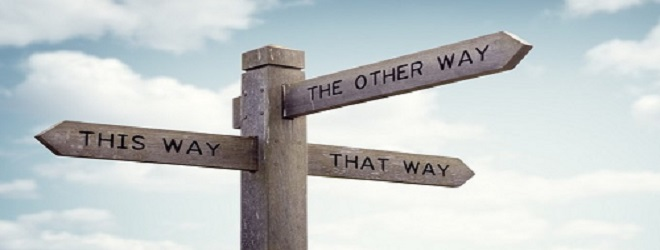

In [ ]:
COMIS = 0.002

In [ ]:
# функция определяет "что делать" и на сколько из остатков денег/акций
def buyorsale(predict):
    '''
    Функция определяет класс действия на основе 
    вектора предсказаний predict
    input: 
    predict - вектора предсказаний
    return:
    класс действия - 
                    0 - ничего не делать
                    1 - покупать
                    2 - продавать
                    
    уверенность в действии 
    '''
    dif_buy = 0
    dif_sell = 0
    len_period = len(predict)
    i_buy = len_period
    i_sell = len_period
    for i in range(len_period-1):
        for j in range(len_period-1):
            dif = predict[j]-predict[i]

            if j > i and dif > dif_buy:
                dif_buy = dif
                i_buy = i  # момент продажи

            if j > i and dif < dif_sell:
                dif_sell = dif
                i_sell = i  # момент покупки
    dif_buy = abs(dif_buy)
    dif_sell = abs(dif_sell)
    #print(i_sell, dif_sell)
    #print( i_buy, dif_buy)
    # выводим "что делать?" и с каким коэф-том
    # коэф-т покупки зависит от соот-я выгод от продажи и покупки 
    # на отрезке будущем 
    if dif_buy == 0 and dif_sell == 0:
        return 0, 0  # спим

    elif  i_buy == 0 and i_buy != i_sell:
          # даем вес dif_sell будущему взависимости от удаленности
          dif_sell_prob = dif_sell*(len_period-i_sell)/len_period
          # сравниваем взвешанную выгоду от действий типа short в дальнем будащем
          # с выгодой от действий для типа long на ближайшем шаге
          if dif_buy > dif_sell_prob:
            # определяем уверенность в покупке от сравнения dif_sell_prob и dif_buy
            force = 1 - dif_sell_prob/dif_buy
            return 1, force  # покупаем
          else:
            return 0, 0  # спим

    elif  i_sell == 0 and i_sell != i_buy:
        # даем вес dif_buy будущему взависимости от удаленности
        dif_buy_prob = dif_buy*(len_period-i_buy)/len_period
        # сравниваем взвешанную выгоду от действий типа long в дальнем будащем
        # с выгодой от действий для типа short на ближайшем шаге
        if dif_sell > dif_buy_prob:
            # определяем уверенность в продаже от сравнения dif_buy_prob и dif_sell
            force = 1 - dif_buy_prob/dif_sell
            return 2, force  # продаем
        else:
          return 0, 0   # спим
    else:
        return 0, 0 # спим



def prepare_data(df_in: pd.DataFrame, 
                 #use_columns:list, 
                 depth:int,
                 scaler: object):
    # обогащаем данные ранее созданной функцией
    ds = make_data(df_in, DIFFBACK, SET_WIND, FEATURES, ROLLS)
    # обогащаем данные ранее созданной функцией
    ds = add_from_datetime(ds)
    # переводим Volume в Log_Volume в df_data
    ds['Log_Volume'] = np.log(df_in['Volume'])
    # Удаление строк с неполными данными
    ds.dropna(inplace=True)
    # оставляем на глубину depth и только нужные колонки
    x_data = ds[TRAIN_COLUMNS][-depth:].values
    # нормализуем 
    x_data = scaler.transform(x_data)
    # выводим с добавлением измерения по axis=0
    return np.expand_dims(x_data, axis=0)



def making_signals(past_df: pd.DataFrame,
                    check_df: pd.DataFrame,
                    pred_lag: int,
                    model: object,
                    control_enter = False,
                    stop_loss = 1.,
                    use_force_action = False,
                    show_unique_signals = True
                    ):
    """
    Args:
        past_df (pd.DataFrame) - прошлые OHCL данные до тестируемых 
        check_df (pd.DataFrame) - тестируемые OHCL данные
        pred_lag: int - шаг предсказания
        model (class) - ранее обученная модель
        control_enter (bool) - контролировать ли вход в сделку
        stop_loss (float) - уровень падения цены (от 0 до 1) при которм нужно продать
        use_force_action (bool): False - выводим чистые действия, 
                                 True - выводим действия с учетом уверенности,
        show_unique_signals (bool) - показать ли состав чистых действий
    
    Return:
         df_signal(pd.DataFrame) - копия OHCL датафрейма из check_df с колонкой Signal
    """
    # сбор действий
    all_actions = []
    # сбор уверенности действия 
    force_actions = []
    # сбор последнего активного действия и цены 
    last_position = [0, 0]
    # итеррируемся по длине изучаемого датафрейма
    # print('metka_1')
    # берем на страте прошлые данные
    for i in tqdm(range(check_df.shape[0]-pred_lag), unit ="step",
                      desc ="Пробегаемся по всем отсчетам"):
        if not i: # берем на страте прошлые данные
            #print('metka_2')
            check_data = past_df.copy()
        # далее отшипываем вначале 1 свечу
        else: #  и присоединяем в коней новую из изучаемого датафрейма
            #print('metka_3')
            check_data = check_data[1:].append(check_df[i:i+1])
        #print('metka_4', check_data.shape)
        # обогащаем данные по аналогии как готовили для убучени
        to_pred = prepare_data(check_data, 
                                #use_columns:list, 
                                DEPTH,     # ранее заданная глубина сбора данных в прошлое
                                X_SCAILER  # ранее инициализированный и обученный скэйлер
                               )

        # предсказание модели
        pred = model.predict(to_pred, verbose=False)
        pred = Y_SCAILER.inverse_transform(pred)   
        if MAKE_LOG: pred = np.exp(pred)
        #print(pred)
        cls_action, force =  buyorsale(pred[0])
        #print(cls_action, force)
        #print()

        
        # переводим текущий ответ сети (0,1,2) в (0,1,-1)
        sign = -1 if cls_action == 2  else 1

        price = check_data.Close[-1]        # текущая цена
        diff = (last_position[1] - price)   # разница цены прошлого активного действия и текущей цены
        proof = (-1)*sign*diff              # разница на знак действия

        # если контролируем вход в сделку
        if control_enter:
            # если вводим не чистое действия (-1,0,1), а его силу*(-1,0,1)
            if use_force_action:
              # если активное действие
              condition_1 = cls_action
            # если вводим чистые действия (-1,0,1)
            else: 
              # активное действие и отличается от прошлого активного действия
              condition_1 = (last_position[0] != cls_action or not cls_action) 
            # если proof>0, то есть хотим купить при падении или продать при росте к прошлому активному действию
            condition_2 = (proof>0)
            # если предполагаемый доход от сделки выше стоимости сделки
            condition_3 = ((proof- COMIS*price) > 0)

            if condition_1 and condition_2 and condition_3:
                all_actions.append(cls_action)  # собираем класс действия
                force_actions.append(force)     # собираем уверенность действия
                last_position[0] = cls_action   # запоминаем отдельно класс действия
                last_position[1] = price        # запоминаем цену действия
            # если класс действия 0 или совпадает с активным прошлым действием   
            else:
                #print(f'Контроль входа в сделку не пройден')
                cls_action = 0
                all_actions.append(cls_action)  # собираем как 0 класс действия
                force_actions.append(1)         # собираем как 100% уверенность действия

        # если не контролируем вход в сделку
        else: # собираем без коррекций
            all_actions.append(cls_action)  # собираем класс действия
            force_actions.append(force)     # собираем уверенность действия
        # если stop_loss не равен 0, то есть контролируем потери
        if (1-stop_loss):
            # если предполагаемое действие не продажа
            # и бумаги в руках упали ниже заданного stop_loss
            if cls_action != 2 and price < last_position[1]*stop_loss:
                print(f'STOP_LOSS на шаге {i}')
                print()
                # корректируем наши последние собранные действия
                all_actions[-1] = 2        # продаем
                force_actions[-1] = 1      # однозначно
                last_position[0] = 2       # фиксируем действие
                last_position[1] = price   # запоминаем цену действия

    # переводим классы сигналов в массив сигналов 
    all_actions = np.array(all_actions)
    signals = np.zeros(all_actions.shape[0]) # массив нулей
    signals[all_actions == 1] =  1           # при покупке сигнал 1
    signals[all_actions == 2] = -1           # при продаже сигнал -1
    if show_unique_signals:
      print(f' Итоговые типы действий {np.unique(signals, return_counts=True)} и их количество')
    # смещаем на pred_lag
    df_signal = check_df[pred_lag:].copy()
    # берем действия действия с учетом их уверенности
    if  use_force_action:
        df_signal['Signal'] = np.array(signals*force_actions)
    # берем чистые действия действия
    else:
        df_signal['Signal'] = np.array(signals)
    # берем чистые действия действия
    return  df_signal

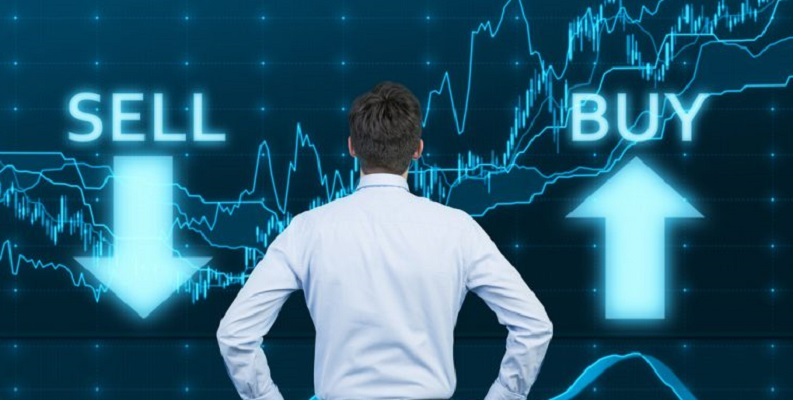

In [ ]:
# длина взгляда назад
BACK = 2*DEPTH + PREDICT_LAG
# данные назад
past_data = df_tiker[-BACK - test_size:-PREDICT_LAG].copy()
# тестируемы датафрейм
test_data = df_tiker[- test_size - PREDICT_LAG :].copy()
# получаем датафрейм с сигналом
df_test_signal = making_signals(past_data,
                                test_data,
                                model = good_model,
                                pred_lag = PREDICT_LAG,
                                control_enter = True,
                                stop_loss = 0.9,
                                use_force_action = False,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/500 [00:00<?, ?step/s]

STOP_LOSS на шаге 433

STOP_LOSS на шаге 441

 Итоговые типы действий (array([-1.,  0.,  1.]), array([ 31, 440,  29])) и их количество


In [ ]:
# длина взгляда назад
BACK = 2*DEPTH + PREDICT_LAG
# данные назад
past_data = df_tiker[-BACK - test_size:-PREDICT_LAG].copy()
# тестируемы датафрейм
test_data = df_tiker[- test_size - PREDICT_LAG :].copy()
# получаем датафрейм с сигналом
df_test_signal_f = making_signals(past_data,
                                test_data,
                                model = good_model,
                                pred_lag = PREDICT_LAG,
                                control_enter = True,
                                stop_loss = 0.9,
                                use_force_action = True,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/500 [00:00<?, ?step/s]

 Итоговые типы действий (array([-1.,  0.,  1.]), array([ 61, 370,  69])) и их количество


# Тестирование на основе  Backtest, Strategy

In [ ]:
!pip install backtesting -q
# Библиотеки backtesting 
from backtesting import Backtest, Strategy
clear_output()

## Тест модели

*Вариант класса когда сигнал к действию получается из входящего датафрейма*

In [ ]:
class Long_n_Short_Strategy(Strategy):

    # stop loss parameter, uses as a sigma * n1
    n1 = 5
    # take profit parameter, uses as a % from current price
    n2 = 6  
    
    def init(self):
      self.signal = self.I(lambda x: x, self.data.Signal, name='Signal')
      self.current_price = self.I(lambda x: x, self.data.Close, name='Close')
         
              
    def next(self):
      # определяем размер/силу действия из сигнали
      size = abs(self.signal[-1])
      signal = self.signal[-1]
      #print('size', size)
      
      if (self.position.is_long and 0 > signal):
          # Текущий капитал (денежные средства плюс активы).
          #print('Текущий капитал ', round(self.equity)) 
          #print('______________________________________________')
          #print('Закрытие позиции LONG')
          # Размер позиции в единицах актива. Отрицательно, если позиция короткая.
          #print('Размер позиции', self.position.size)
          self.position.close()
          
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в денежных единицах.
          #print('Прибыль/убыток (позиции в деньгах', self.position.pl)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в процентах.
          #print('Прибыль/убыток позиции в %', self.position.pl_pct)
          # True, если позиция длинная (размер позиции положительный).
          #print('position.is_long', self.position.is_long) 
          # True, если позиция короткая (размер позиции отрицательный).
          #print('position.is_short', self.position.is_short)
          #print('______________________________________________')
          #print()

      if (self.position.is_short and 0 < signal):
          #print('Текущий капитал ', round(self.equity)) 
          #print('______________________________________________')
          #print('Закрытие позиции SHORT')
          # Размер позиции в единицах актива. Отрицательно, если позиция короткая.
          #print('Размер позиции', self.position.size)
          self.position.close()
          

      if (0 < signal):
          # Текущий капитал (денежные средства плюс активы).
          #print('Текущий капитал ', round(self.equity)) 
          #print('______________________________________________')
          #print('вход в покупку')
          # Предполагаем рост, соответственно выставляем sl чуть меньше текущей цены в %
          # Определяем волатильность цены и берем от нее максимум ...
          sigma = np.std(self.current_price[:10])
          sl = self.current_price[-1] - sigma * self.n1
          tp = self.current_price[-1] * (1 + self.n2/100)
          # покупаем на разницу до нового size
          if self.position.size:
            current_size = 1 if abs(self.position.size) * self.current_price[-1] / CAPITAL > 1 else abs(self.position.size) * self.current_price[-1] / CAPITAL
          else:
            current_size = 0 
          size = size - current_size
          if 1 > size > 0:
            if not ( 0 < size < 1 or round(size) == size ):
              print('обновленный сайз, текущий сайз, сигнал', size, current_size, signal)  
            self.buy(size = size,sl=sl,tp=tp)
          elif size < 0:
            self.sell(size = abs(size))      
          else:
            self.buy(sl=sl,tp=tp)
          #print('orders ', self.orders) 
          #print('______________________________________________')
          #print()

      if (0 > signal):
          # Текущий капитал (денежные средства плюс активы).
          #print('Текущий капитал ', round(self.equity)) 
          #print('______________________________________________')
          #print('вход в продажу')
          # Предполагаем падение, соответственно выставляем sl чуть выше текущей цены в %
          # Определяем волатильность цены и берем от нее максимум ...
          sigma = np.std(self.current_price[:10])
          sl = self.current_price[-1] + sigma * self.n1
          tp = self.current_price[-1]  * (1 - self.n2/100)
          if self.position.size:
            current_size = 1 if abs(self.position.size) * self.current_price[-1] / CAPITAL > 1 else abs(self.position.size) * self.current_price[-1] / CAPITAL
          else:
            current_size = 0 
          size = size - current_size
          if 1 > size > 0:
            if not ( 0 < size < 1 or round(size) == size ):
              print('обновленный сайз, текущий сайз, сигнал', size, current_size, signal)  
            self.sell(size = size,sl=sl,tp=tp)
          elif size < 0:
            self.buy(size = abs(size))      
          else:
            self.sell(sl=sl,tp=tp)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в денежных единицах.
          #print('Прибыль/убыток (позиции в деньгах', self.position.pl)
          # Прибыль (положительная) или убыток (отрицательная) текущей позиции в процентах.
          #print('Прибыль/убыток позиции в %', self.position.pl_pct)
          # True, если позиция длинная (размер позиции положительный).
          #print('position.is_long', self.position.is_long) 
          # True, если позиция короткая (размер позиции отрицательный).
          #print('position.is_short', self.position.is_short)
          #print('______________________________________________')
          #print()

In [ ]:
# Стратегия Long_n_Short_Strategy, Long_Strategy, Short_Strategy
CAPITAL = 100000
bt = Backtest(df_test, Long_n_Short_Strategy, cash = CAPITAL, commission=COMIS,
#bt = Backtest(df_test_signal_f, Long_n_Short_Strategy, cash = CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
print(stats)

#stats, heatmap = bt.optimize(
#    n1=range(1, 5, 1),
#    n2=range(1, 10, 1),
#    maximize='Equity Final [$]',
#    max_tries=200,
#    random_state=0,
#    return_heatmap=True)

#hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
#sns.heatmap(hm[::-1], cmap='viridis')

Start                     2022-01-03 09:30...
End                       2023-04-05 15:30...
Duration                    457 days 05:00:00
Exposure Time [%]                   99.773551
Equity Final [$]                784760.650631
Equity Peak [$]                 825430.735844
Return [%]                         684.760651
Buy & Hold Return [%]               -9.450341
Return (Ann.) [%]                  417.025976
Volatility (Ann.) [%]              113.115891
Sharpe Ratio                         3.686714
Sortino Ratio                       57.733024
Calmar Ratio                        53.512889
Max. Drawdown [%]                   -7.793001
Avg. Drawdown [%]                   -0.771621
Max. Drawdown Duration       41 days 23:00:00
Avg. Drawdown Duration        2 days 04:00:00
# Trades                                 1507
Win Rate [%]                        49.966821
Best Trade [%]                       4.660068
Worst Trade [%]                     -3.934185
Avg. Trade [%]                    

### Сохранение весов модели

Тут вы можете сохранить вами обученную модель в указанную вами папку

In [ ]:
#path_model = '... пакка куда вы пишете веса вашей модели/'  # куда пишет weights
#good_model.save_weights(filepath=path_model)

## Подгрузка ранее сохраненных структуры и весов модели

In [ ]:
import gdown  # библиотека по работе с файлами в том числе и с гугл_диска

ВНИМАНИЕ!!!!

Тут какое-то время будут доступна ссылка список найденных сетей моим ноутом

In [ ]:
name_file = 'bestnets.npy'
# файл
url_file = 'https://drive.google.com/file/d/1DiBYtLXhyyqBqNPj7S25Zlpa31i4ocEz/view?usp=share_link'
# левая часть адреса
main = 'https://drive.google.com/uc?id='
# Подгружаем на диск ноута файл индексации
part_url = url_file.split('/')[-2]
gdown.download(main + part_url, name_file, quiet=False)

save_nets = np.load(name_file, allow_pickle = True)

Downloading...
From: https://drive.google.com/uc?id=1DiBYtLXhyyqBqNPj7S25Zlpa31i4ocEz
To: /content/drive/Othercomputers/Home/Documents/Colab_notebooks/Notebooks_GoogleDisk/РАБОТА _ УИИ/Трейдинг с нейросетями/Подбор сети генетикой/bestnets.npy
100%|██████████| 441/441 [00:00<00:00, 808kB/s]


На всякий случай это список ручной, tго можно в код перевести

    bot_pop = [7, 1, None, 1, 16, 7, 0, 0, 0, 0]
    set_bloks = [[], [], ['Conv1DT'], ['Dense'], [], [], []]
    bot = [[], [], [32, 5], [256], [], [], []]

    net = [bot_pop, set_bloks, bot]
    save_nets = [net]

Если вы хотите загрузить веса вашей модели, то вы также должны:
- или вручную записать структурц вашей модели.
- или загрузить из папки как уже делали ранее после кода генетики 

    `directory = ' куда вы сохраняли списки /`
    
    `save_nets = np.load(directory+'bestnets.npy', allow_pickle = True)`

In [ ]:
########### папаметпы для генерируемых сетей ###################################
activ_lays =['relu', 'elu', 'tanh', 'sigmoid', 'selu', 'softmax',
             'softplus', 'softsign', 'hard_sigmoid', 'exponential']
# нужное количество входных нейроной
neiro_out = y_train.shape[1]      

# функции активации для выходного слоя                  
activ_out = ['linear'] 
# генерируем список с n моделями, по умолчанию  n = 1
load_model = getnetfrombest(save_nets, activ_lays,
                            activ_out, neiro_out,
                            limit = TIMELIMIT_1, # время на генерацию модели
                            n = 1)[0] # берем из спика сразу с индексом 0
load_model.call = tf.function(load_model.call)
# Отображение сводки модели
load_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 29, 54)]     0           []                               
                                                                                                  
 conv1d_transpose (Conv1DTransp  (None, 29, 32)      8672        ['input_1[0][0]']                
 ose)                                                                                             
                                                                                                  
 conv1d_transpose_1 (Conv1DTran  (None, 29, 32)      5152        ['conv1d_transpose[0][0]']       
 spose)                                                                                           
                                                                                              

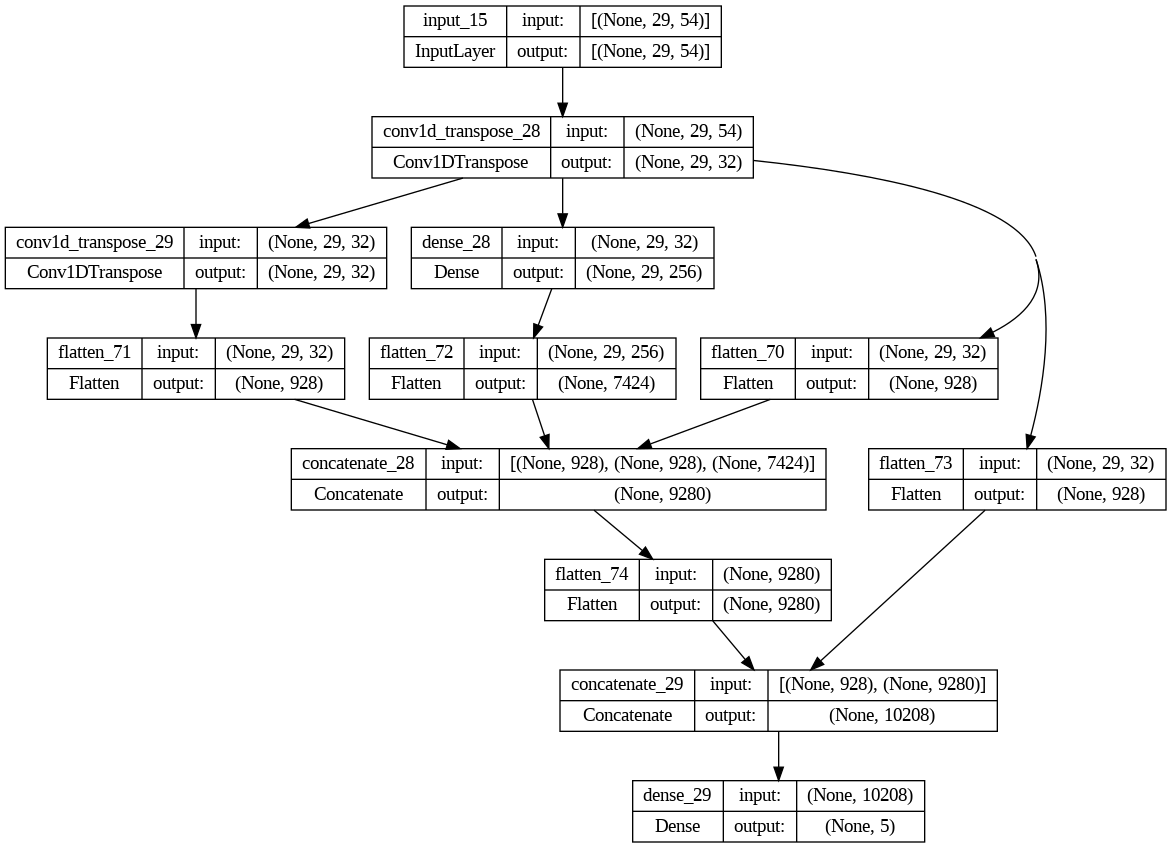

In [ ]:
tf.keras.utils.plot_model(load_model, show_shapes=True)

ВНИМАНИЕ!!!!

Тут какое-то время будут доступны ссылки на веса модели найденой и обученной моим ноутом.

Вы по примеру можете сделать ссылки на индексы и веса вами сохраненной модели 

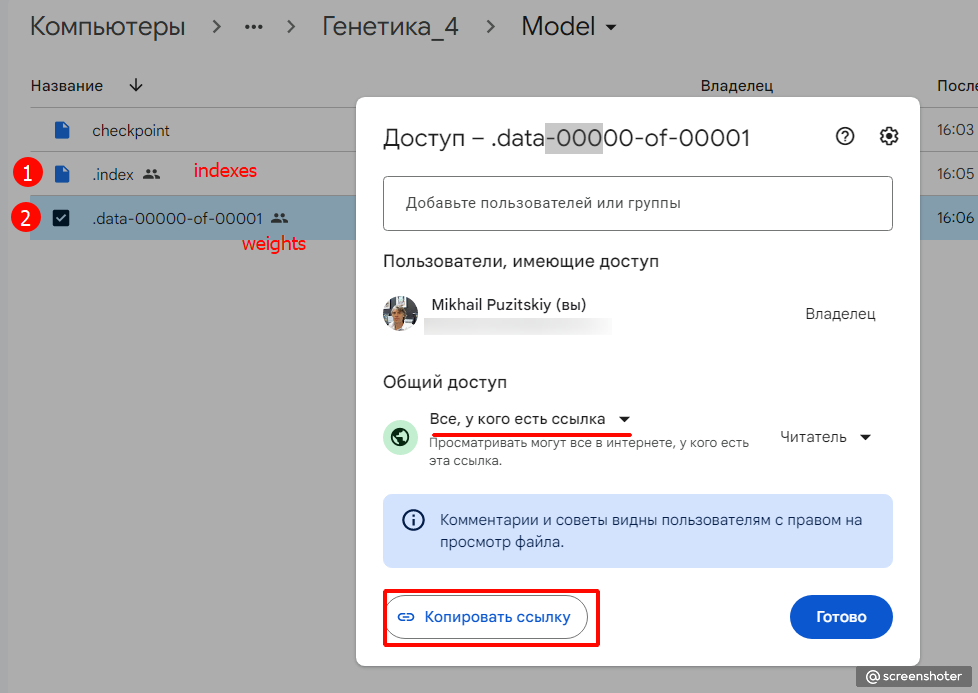

In [ ]:
name_nodel = 'load_model'

# публичные ссылки на файлы
# файл индексации
url_index = 'https://drive.google.com/file/d/1-Wx_HNXNLOZi8jsytdsqXzpLOtlpiSH6/view?usp=share_link'
# файл весов
url_weights = 'https://drive.google.com/file/d/1-cqvIJXp3mhg9f2cTwoBFY3y64BPVczE/view?usp=share_link'

# левая часть адреса
main = 'https://drive.google.com/uc?id='
# Подгружаем на диск ноута файл индексации
index_id = url_index.split('/')[-2]
w_index = name_nodel + '.index'
gdown.download(main + index_id, w_index, quiet=False)

# Подгружаем на диск ноута сами веса
weights_id = url_weights.split('/')[-2]
weights = name_nodel + '.data-00000-of-00001'
gdown.download(main + weights_id, weights, quiet=False)

# загружаем веса в сформированный корпус модели
# path_weights = '/content/' +  name_nodel
path_weights = name_nodel
load_model.load_weights(path_weights)

Downloading...
From: https://drive.google.com/uc?id=1-Wx_HNXNLOZi8jsytdsqXzpLOtlpiSH6
To: /content/drive/Othercomputers/Home/Documents/Colab_notebooks/Notebooks_GoogleDisk/РАБОТА _ УИИ/Трейдинг с нейросетями/Подбор сети генетикой/load_model.index
100%|██████████| 1.25k/1.25k [00:00<00:00, 2.29MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-cqvIJXp3mhg9f2cTwoBFY3y64BPVczE
To: /content/drive/Othercomputers/Home/Documents/Colab_notebooks/Notebooks_GoogleDisk/РАБОТА _ УИИ/Трейдинг с нейросетями/Подбор сети генетикой/load_model.data-00000-of-00001
100%|██████████| 589k/589k [00:00<00:00, 42.5MB/s]


### Тест модели

*Вариант класса когда сигнал к действию получается из входящего датафрейма*

In [ ]:
# длина взгляда назад
BACK = 2*DEPTH + PREDICT_LAG
# данные назад
past_data = df_tiker[-BACK - test_size:-PREDICT_LAG].copy()
# тестируемый датафрейм
test_data = df_tiker[- test_size - PREDICT_LAG :].copy()
# получаем датафрейм с сигналом
df_test_signal_f = making_signals(past_data,
                                test_data,
                                model = load_model,
                                pred_lag = PREDICT_LAG,
                                control_enter = True,
                                stop_loss = 0.90,
                                use_force_action = True,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/500 [00:00<?, ?step/s]

 Итоговые типы действий (array([-1.,  0.,  1.]), array([ 88, 348,  64])) и их количество


In [ ]:
# длина взгляда назад
BACK = 2*DEPTH + PREDICT_LAG
# данные назад
past_data = df_tiker[-BACK - test_size:-PREDICT_LAG].copy()
# тестируемый датафрейм
test_data = df_tiker[- test_size - PREDICT_LAG :].copy()
# получаем датафрейм с сигналом
df_test_signal = making_signals(past_data,
                                test_data,
                                model = load_model,
                                pred_lag = PREDICT_LAG,
                                control_enter = True,
                                stop_loss = 0.90,
                                use_force_action = False,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/500 [00:00<?, ?step/s]

STOP_LOSS на шаге 113

STOP_LOSS на шаге 368

STOP_LOSS на шаге 432

STOP_LOSS на шаге 440

 Итоговые типы действий (array([-1.,  0.,  1.]), array([ 42, 429,  29])) и их количество


In [ ]:
# Стратегия Long_n_Short_Strategy, Long_Strategy, Short_Strategy
CAPITAL = 100000
bt = Backtest(df_test_signal, Long_n_Short_Strategy, cash = CAPITAL, commission=COMIS,
#bt = Backtest(df_test_signal_f, Long_n_Short_Strategy, cash = CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Текущий капитал  100000
______________________________________________
вход в покупку
orders  (<Order size=1.0, contingent=0>,)
______________________________________________

Текущий капитал  100499
______________________________________________
Закрытие позиции LONG
Размер позиции 3036
Прибыль/убыток (позиции в деньгах 498.6919767150782
Прибыль/убыток позиции в % 0.004987273694478711
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  100499
______________________________________________
вход в продажу
Прибыль/убыток (позиции в деньгах 498.6919767150782
Прибыль/убыток позиции в % 0.004987273694478711
position.is_long True
position.is_short False
______________________________________________

Текущий капитал  100196
______________________________________________
Закрытие позиции SHORT
Размер позиции -1
Текущий капитал  100196
______________________________________________
вход в покупку
orders  (<Order size=1.0, contingent=0>

Start                     2020-12-31 00:00:00
End                       2022-12-23 00:00:00
Duration                    722 days 00:00:00
Exposure Time [%]                        57.2
Equity Final [$]                115102.750136
Equity Peak [$]                 116461.096664
Return [%]                           15.10275
Buy & Hold Return [%]               -6.084101
Return (Ann.) [%]                    7.346328
Volatility (Ann.) [%]               13.355141
Sharpe Ratio                         0.550075
Sortino Ratio                        0.954931
Calmar Ratio                         0.627384
Max. Drawdown [%]                  -11.709454
Avg. Drawdown [%]                   -4.441267
Max. Drawdown Duration      224 days 00:00:00
Avg. Drawdown Duration       89 days 00:00:00
# Trades                                   37
Win Rate [%]                        62.162162
Best Trade [%]                      12.724001
Worst Trade [%]                     -6.946147
Avg. Trade [%]                    